# Classifier for Human Brain Mental Attention State using EEG BCI-based data
### 21100130, 21100187

In [44]:
import os
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy import signal
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.metrics import accuracy_score
import seaborn as sns
import time
from tqdm import tqdm, tqdm_notebook
import antropy as ant
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

np.random.seed(42)

SAMP_FREQ = 128 # SAMPLING FREQUENCY Hz (samples/second)
CLASSES = {
    0: 'focused',
    1: 'unfocused',
    2: 'drowsy'
}

ONEHOT = {
    0: np.array([1,0,0]),
    1: np.array([0,1,0]),
    2: np.array([0,0,1])
}

In [2]:
!pip install antropy librosa geneticalgorithm

     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
  Created wheel for antropy: filename=antropy-0.1.4-cp37-none-any.whl size=16145 sha256=2442fe0a66402bbd3a7d6148653787fc7678601d3adcf367dda6f4b381762899
  Stored in directory: /root/.cache/pip/wheels/ea/18/dd/bc916fbf8fd484b9722551f73a0314f0aacfc3c1cdf5f4b2ca
  Created wheel for func-timeout: filename=func_timeout-4.3.5-cp37-none-any.whl size=15079 sha256=1b4e83cf6bc7ca1038db6e2a55b9dfc5e27c51141e7462c3bb0f3f3c7dc0308d
  Stored in directory: /root/.cache/pip/wheels/46/7c/4f/24f1d2d5bbff92219debe7ea19af84f76ddeb90dd4ec544f26
Successfully built antropy func-timeout


## Dataset Load & Visualize

In [3]:
! [ ! -f '/content/eeg-data.zip' ] && gdown 'https://drive.google.com/uc?id=163LQWJzuyUy5nQlNsLWg4o-IiQJ72IbN'
! [ ! -d '/content/data' ] && unzip '/content/eeg-data.zip' -d '/content/data' 

Downloading...
From: https://drive.google.com/uc?id=163LQWJzuyUy5nQlNsLWg4o-IiQJ72IbN
To: /content/eeg-data.zip
584MB [00:08, 71.0MB/s]
Archive:  /content/eeg-data.zip
  inflating: /content/data/EEG Data/eeg_record1.mat  
  inflating: /content/data/EEG Data/eeg_record10.mat  
  inflating: /content/data/EEG Data/eeg_record11.mat  
  inflating: /content/data/EEG Data/eeg_record12.mat  
  inflating: /content/data/EEG Data/eeg_record13.mat  
  inflating: /content/data/EEG Data/eeg_record14.mat  
  inflating: /content/data/EEG Data/eeg_record15.mat  
  inflating: /content/data/EEG Data/eeg_record16.mat  
  inflating: /content/data/EEG Data/eeg_record17.mat  
  inflating: /content/data/EEG Data/eeg_record18.mat  
  inflating: /content/data/EEG Data/eeg_record19.mat  
  inflating: /content/data/EEG Data/eeg_record2.mat  
  inflating: /content/data/EEG Data/eeg_record20.mat  
  inflating: /content/data/EEG Data/eeg_record21.mat  
  inflating: /content/data/EEG Data/eeg_record22.mat  
  inflati

In [4]:
DATA_FOLDER = '/content/data'

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.mat')))

NUM_FILES_ALL = len(filenames) # with habituation and trial experiments both
print("Total number of records: " + str(NUM_FILES_ALL))

'''
Each participant took part in 7 experiments, performing at most one experiment per day. 
The first 2 experiments were used for habituation, and the last 5 trials were used for collecting the data. 
The first 7 experiments belong to Subject 1, the next 7 experiments belong to Subject 2, and go on. 
However, Subject 5 could not complete the last experiment. 
Therefore, there are 34 records in the dataset.
'''


img_folder_path = '/'.join(filenames[0].split('/')[:-1])
filenames_trials = []  # remove records of habituation first, second of each subject's set out of 7
for i in range(3, NUM_FILES_ALL, 7):
    for j in range(i, min(i+5, NUM_FILES_ALL+1)):
        filenames_trials.append(img_folder_path+'/'+'eeg_record'+str(j)+'.mat')

print(filenames_trials)
NUM_FILES = len(filenames_trials)
print("Number of trial experiment records: " + str(NUM_FILES))

Total number of records: 34
['/content/data/EEG Data/eeg_record3.mat', '/content/data/EEG Data/eeg_record4.mat', '/content/data/EEG Data/eeg_record5.mat', '/content/data/EEG Data/eeg_record6.mat', '/content/data/EEG Data/eeg_record7.mat', '/content/data/EEG Data/eeg_record10.mat', '/content/data/EEG Data/eeg_record11.mat', '/content/data/EEG Data/eeg_record12.mat', '/content/data/EEG Data/eeg_record13.mat', '/content/data/EEG Data/eeg_record14.mat', '/content/data/EEG Data/eeg_record17.mat', '/content/data/EEG Data/eeg_record18.mat', '/content/data/EEG Data/eeg_record19.mat', '/content/data/EEG Data/eeg_record20.mat', '/content/data/EEG Data/eeg_record21.mat', '/content/data/EEG Data/eeg_record24.mat', '/content/data/EEG Data/eeg_record25.mat', '/content/data/EEG Data/eeg_record26.mat', '/content/data/EEG Data/eeg_record27.mat', '/content/data/EEG Data/eeg_record28.mat', '/content/data/EEG Data/eeg_record31.mat', '/content/data/EEG Data/eeg_record32.mat', '/content/data/EEG Data/eeg_re

data: (357224, 25)


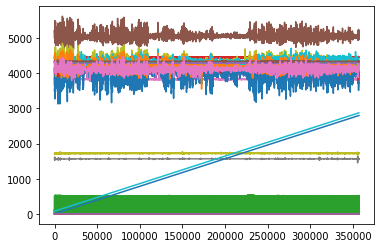


data_eeg: (357224, 14)


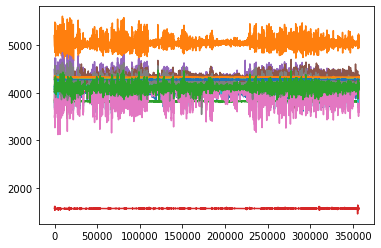


trials: (1, 2, 14, 128)

data: (380344, 25)


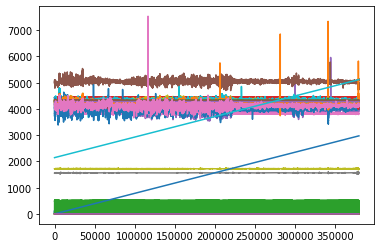


data_eeg: (380344, 14)


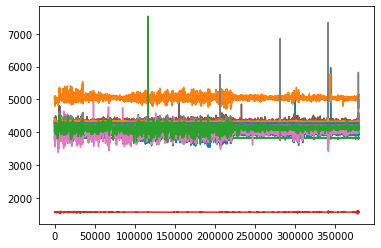


trials: (1, 2, 14, 128)

data: (351204, 25)


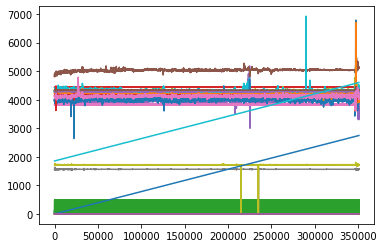


data_eeg: (351204, 14)


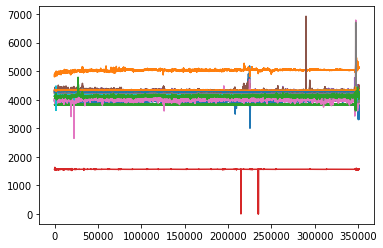


trials: (1, 2, 14, 128)



In [5]:
'''
Each Matlab file contains the object of the data acquired from EMOTIV device during one experiment. 
The raw data is contained in o.data, which is array of size {number-of-samples}x25, thus o.data(:,i) comprises one data channel. 
The sampling frequency is 128 Hz. The list of data channels and their numerical ids is given below per EMOTIV documentation;
The EEG data is in the channels 4:17.
'''

for i in range(3):
    record = loadmat(filenames_trials[i])
    mdata = record['o']  # main object 
    sample1 = {n: mdata[n][0,0] for n in mdata.dtype.names}

    data = sample1['data']
    trials = sample1['trials']

    print('data:', data.shape)
    plt.plot(data)
    plt.show()

    data_eeg = data[:,4:18]
    print('\ndata_eeg:', data_eeg.shape)
    plt.plot(data_eeg)
    plt.show()

    print('\ntrials:', trials.shape)
    print()

## Data Partitioning

In [135]:
def scale_std(x): # same standard scalar as mean
    return preprocessing.StandardScaler().fit(x).transform(x)

def scale_minmax(x): 
    return preprocessing.MinMaxScaler().fit(x).transform(x)

def scale_maxabs(x): 
    return preprocessing.MaxAbsScaler().fit(x).transform(x)

def scale_robust(x):
    return preprocessing.RobustScaler().fit(x).transform(x)


def visualize(x_train_list, y_train): # visualize final training data samples
    for i in range(5):
        print(CLASSES[np.argmax(y_train[i])], x_train_list[i].shape)
        plt.plot(x_train_list[i])
        plt.show()


def get_signal_data(trial_seconds=6, binary_class=False, feature_scalar_func=None):
    global SAMP_FREQ, ONEHOT
    x = []
    y = []

    trial_length = trial_seconds*SAMP_FREQ
    MARK_10MIN, MARK_20MIN = 10*60*SAMP_FREQ, 20*60*SAMP_FREQ 
    NUM_TRIALS = MARK_10MIN//trial_length
    NUM_CHAN = 14

    print(MARK_10MIN, trial_length, NUM_TRIALS)


    for fn in filenames_trials:
        record = loadmat(fn)
        mdata = record['o']  # main object 
        ndata = {n: mdata[n][0,0] for n in mdata.dtype.names}
        
        data = ndata['data'][:,4:18] # 4-17 EEG data channels only from the experiments
        ns = data.shape[0]

        '''
        Experiment labels
        Focused: 0 to 10 min
        Unfocused: 10 to 20min
        Sleep: 20 to end of experiments
        '''

        focused = np.array(data[:MARK_10MIN])
        if feature_scalar_func:
            focused = feature_scalar_func(focused)

        focused_trials = np.split(focused, NUM_TRIALS)

        x += focused_trials # from the start
        y += [ONEHOT[0]]*NUM_TRIALS # focused


        unfocused = data[MARK_10MIN:MARK_20MIN]
        if feature_scalar_func:
            unfocused = feature_scalar_func(unfocused)

        unfocused_trials = np.split(unfocused, NUM_TRIALS)
        x += unfocused_trials
        y += [ONEHOT[1]]*NUM_TRIALS # unfocused


        drowsy = data[MARK_20MIN:MARK_20MIN+MARK_10MIN]
        if feature_scalar_func:
            drowsy = feature_scalar_func(drowsy)

        min_splits = drowsy.shape[0]//trial_length
        drowsy = drowsy[:min_splits*trial_length]
        drowsy_trials = np.split(drowsy, min_splits) # for the entire drowsy duration split it into trials

        x += drowsy_trials # until the end

        if binary_class == True:
          y += [ONEHOT[1]]*NUM_TRIALS # UNFOCUSED USED
        else:
          y += [ONEHOT[2]]*NUM_TRIALS # DROWSY USED
        
    print(len(x), len(y))
    return x, y

def get_signal_data_CB(trial_seconds=6, binary_class=False, feature_scalar_func=None):
    global SAMP_FREQ, ONEHOT
    x = []
    y = []

    trial_length = trial_seconds*SAMP_FREQ
    MARK_10MIN, MARK_20MIN = 10*60*SAMP_FREQ, 20*60*SAMP_FREQ 
    NUM_TRIALS = MARK_10MIN//trial_length
    NUM_CHAN = 14

    print(MARK_10MIN, trial_length, NUM_TRIALS)


    for fn in filenames_trials:
        record = loadmat(fn)
        mdata = record['o']  # main object 
        ndata = {n: mdata[n][0,0] for n in mdata.dtype.names}
        
        data = ndata['data'][:,4:18] # 4-17 EEG data channels only from the experiments
        ns = data.shape[0]

        '''
        Experiment labels
        Focused: 0 to 10 min
        Unfocused: 10 to 20min
        Sleep: 20 to end of experiments
        '''

        focused = np.array(data[:MARK_10MIN])

        if feature_scalar_func:
            focused = feature_scalar_func(focused)

        pieces = focused.shape[0]//trial_length
        focused_trials = np.split(focused, pieces)

        x += focused_trials # from the start
        y += [ONEHOT[0]]*pieces # focused


        unfocused = data[MARK_10MIN:MARK_10MIN+MARK_10MIN//2]

        if feature_scalar_func:
            unfocused = feature_scalar_func(unfocused)

        pieces = unfocused.shape[0]//trial_length
        unfocused_trials = np.split(unfocused, pieces)

        x += unfocused_trials
        y += [ONEHOT[1]]*pieces # unfocused


        drowsy = data[MARK_20MIN:MARK_20MIN+MARK_10MIN//2]

        if feature_scalar_func:
            drowsy = feature_scalar_func(drowsy)

        pieces = drowsy.shape[0]//trial_length
        drowsy = drowsy[:pieces*trial_length]
        drowsy_trials = np.split(drowsy, pieces) # for the entire drowsy duration split it into trials

        x += drowsy_trials # until the end

        if binary_class == True:
          y += [ONEHOT[1]]*pieces # UNFOCUSED USED
        else:
          y += [ONEHOT[2]]*pieces # DROWSY USED
        
    print(len(x), len(y))
    return x, y

In [183]:
  features = [
              'perm_entropy',
              # 'spectral_entropy',  
              'svd_entropy', 
              'app_entropy', 
              # 'sample_entropy', 
              'num_zerocross',
              'petrosian_fd',
              'katz_fd',
              'higuchi_fd',
              # 'detrended_fluctuation'
            ]

In [169]:
def generate_signal_features(trial_seconds, binary_class, feature_scalar_func, save_fname):
  x, y = get_signal_data(trial_seconds=trial_seconds, binary_class=binary_class, feature_scalar_func=feature_scalar_func)
  print(x[0].shape)

  y_n = np.argmax(y, axis=1)
  print(np.shape(y_n))
  print('focused, unfocused, drowsy')
  print(np.shape(np.where(y_n == 0))[1], np.shape(np.where(y_n == 1))[1], np.shape(np.where(y_n == 2))[1])

  plt.plot(x[0])
  plt.show()

  xp = []
  yp = []

  for i in tqdm_notebook(range(0, len(x))):
      xp.append([])
      yp.append(y[i])

      for c in range(14):
          channel_features = np.array([
            (ant.perm_entropy(x[i][:,c], normalize=True)),
            # (ant.spectral_entropy(x[i][:,c], sf=100, method='welch', normalize=True)),
            (ant.svd_entropy(x[i][:,c], normalize=True)),
            (ant.app_entropy(x[i][:,c])),
            # (ant.sample_entropy(x[i][:,c])),
            (ant.num_zerocross(x[i][:,c])),
            (ant.petrosian_fd(x[i][:,c])),
            (ant.katz_fd(x[i][:,c])),
            (ant.higuchi_fd(x[i][:,c])),
            # (ant.detrended_fluctuation(x[i][:,c])),
          ])
          xp[-1].append(channel_features)
          
          
  xp = np.array(xp)
  np.save(save_fname, xp)
  print('Saved as ', save_fname)

  return xp, yp

76800 768 100
7179 7200
(768, 14)
(7200,)
focused, unfocused, drowsy
2400 4800 0


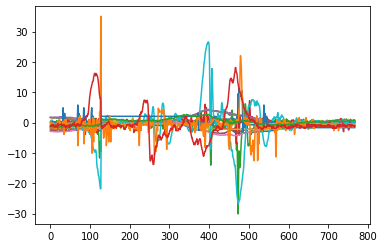

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Saved as  xp_6_3_std.npy
focused (14, 7)


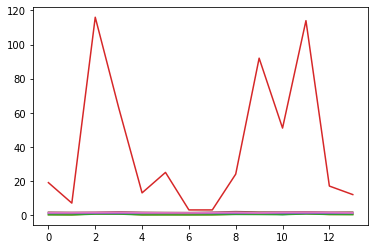

focused (14, 7)


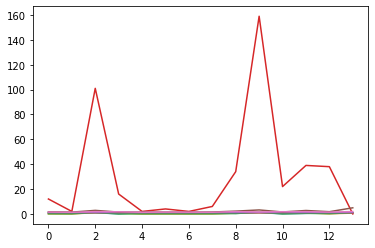

focused (14, 7)


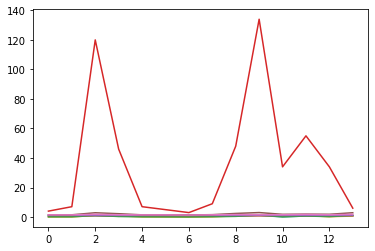

focused (14, 7)


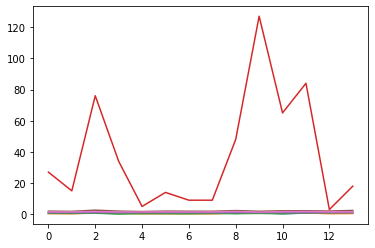

focused (14, 7)


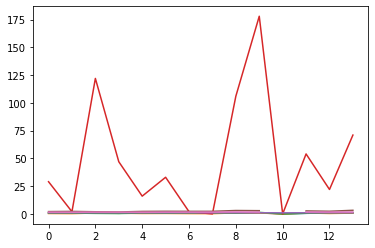

In [170]:
xp, yp = generate_signal_features(trial_seconds=6, binary_class=True, feature_scalar_func=scale_std, save_fname='xp_6_3_std.npy')
visualize(xp, yp)

In [ ]:
xp, yp = generate_signal_features(trial_seconds=6, binary_class=False, feature_scalar_func=scale_minmax, save_fname='xp_6_3_minmax.npy')
visualize(xp, yp)

In [ ]:
xp, yp = generate_signal_features(trial_seconds=6, binary_class=False, feature_scalar_func=scale_maxabs, save_fname='xp_6_3_maxabs.npy)
visualize(xp, yp)

In [ ]:
xp, yp = generate_signal_features(trial_seconds=6, binary_class=False, feature_scalar_func=scale_robust, save_fname='xp_6_3_robust.npy')
visualize(xp, yp)

In [ ]:
xp, yp = generate_signal_features(trial_seconds=6, binary_class=False, feature_scalar_func=None, save_fname='xp_6_3.npy')
visualize(xp, yp)

(4594, 14, 7) (1436, 14, 7)
(1149, 14, 7)
unfocused (14, 7)


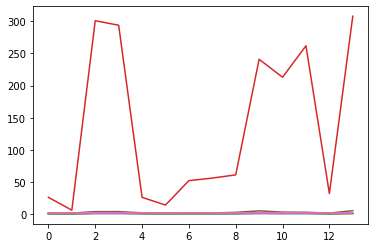

unfocused (14, 7)


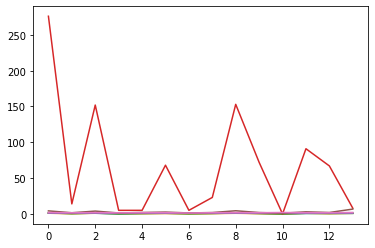

unfocused (14, 7)


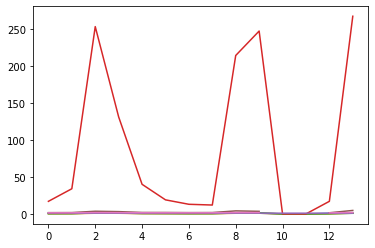

focused (14, 7)


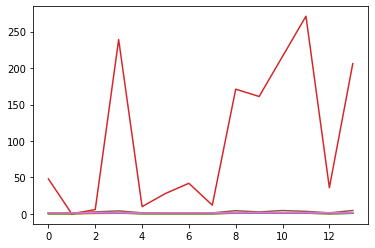

focused (14, 7)


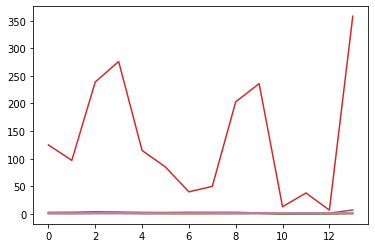

In [171]:
xp = np.load('xp_6_3_std.npy')
TOTAL_SAMPLES = len(xp)
TEST_RATIO = 0.2 # same as validation ratio

x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size=TEST_RATIO, random_state=42) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=TEST_RATIO, random_state=42)

x_train_list = x_train

x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(x_train.shape, x_test.shape)
print(x_val.shape)
visualize(x_train_list, y_train)

unfocused (14, 7)


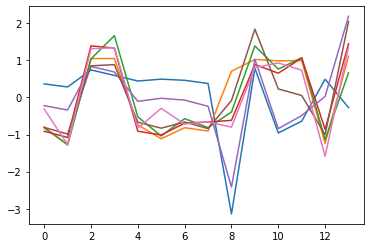

unfocused (14, 7)


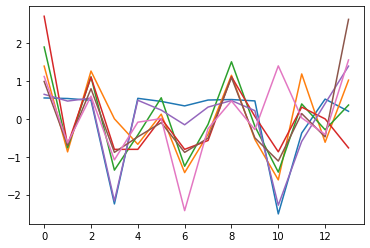

unfocused (14, 7)


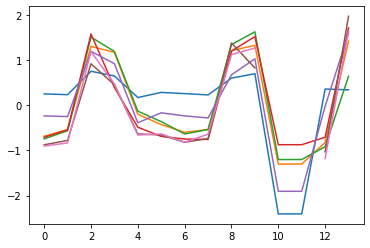

focused (14, 7)


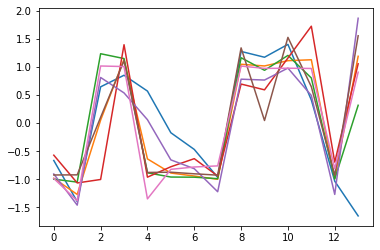

focused (14, 7)


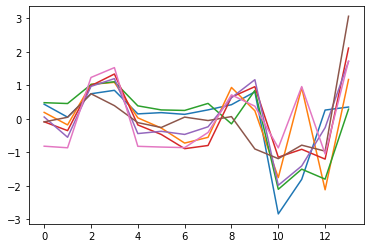

In [173]:
xpn = []
for i in range(len(x_train)):
  xpn.append(scale_std(x_train[i]))
visualize(xpn, y_train)

# HNGFS


In [174]:
tf.compat.v1.disable_eager_execution()

In [176]:
class ANFIS:

    def __init__(self, n_inputs, n_rules, learning_rate=1e-2):
        tf.compat.v1.reset_default_graph() 
        self.n = n_inputs
        self.m = n_rules
        self.inputs = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs))  # Input
        self.targets = tf.compat.v1.placeholder(tf.float32, shape=None)  # Desired output
        mu = tf.compat.v1.get_variable("mu", [n_rules * n_inputs], initializer=tf.random_normal_initializer(0, 1))  # Means of Gaussian MFS
        sigma = tf.compat.v1.get_variable("sigma", [n_rules * n_inputs], initializer=tf.random_normal_initializer(0, 1))  # Standard deviations of Gaussian MFS
        y = tf.compat.v1.get_variable("y", [1, n_rules], initializer=tf.random_normal_initializer(0, 1))  # Sequent centers

        self.params = tf.compat.v1.trainable_variables()

        self.rul = tf.reduce_prod(
            tf.reshape(tf.exp(-0.5 * tf.square(tf.subtract(tf.tile(self.inputs, (1, n_rules)), mu)) / tf.square(sigma)),
                       (-1, n_rules, n_inputs)), axis=2)  # Rule activations
        
        # Fuzzy base expansion function:
        num = tf.reduce_sum(tf.multiply(self.rul, y), axis=1)
        den = tf.clip_by_value(tf.reduce_sum(self.rul, axis=1), 1e-12, 1e12)
        self.out = tf.divide(num, den)

        # self.loss = tf.compat.v1.losses.huber_loss(self.targets, self.out)  # Loss function computation
        self.loss = tf.sqrt(tf.compat.v1.losses.mean_squared_error(self.targets, self.out)) # RMSE
        
        self.optimize = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)  # Optimization step
        self.init_variables = tf.compat.v1.global_variables_initializer()  # Variable initializer

    def infer(self, sess, x, targets=None):
        if targets is None:
            return sess.run(self.out, feed_dict={self.inputs: x})
        else:
            return sess.run([self.out, self.loss], feed_dict={self.inputs: x, self.targets: targets})

    def train(self, sess, x, targets):
        yp, l, _ = sess.run([self.out, self.loss, self.optimize], feed_dict={self.inputs: x, self.targets: targets})
        return l, yp

    def plotmfs(self, sess):
        mus = sess.run(self.params[0])
        mus = np.reshape(mus, (self.m, self.n))
        sigmas = sess.run(self.params[1])
        sigmas = np.reshape(sigmas, (self.m, self.n))
        y = sess.run(self.params[2])
        xn = np.linspace(-1.5, 1.5, 1000)
        for r in range(self.m):
            if r % 4 == 0:
                plt.figure(figsize=(11, 6), dpi=80)
            plt.subplot(2, 2, (r % 4) + 1)
            ax = plt.subplot(2, 2, (r % 4) + 1)
            ax.set_title("Rule %d, sequent center: %f" % ((r + 1), y[0, r]))
            for i in range(self.n):
                plt.plot(xn, np.exp(-0.5 * ((xn - mus[r, i]) ** 2) / (sigmas[r, i] ** 2)))

In [177]:
def train_anfis(data, n_inputs, m, alpha, num_epochs, predict=False):
  x_train_, y_train_, x_test_, y_test_ = data

  fis = ANFIS(n_inputs=n_inputs, n_rules=m, learning_rate=alpha) # 1 , 14, 11710

  with tf.compat.v1.Session() as sess:
      sess.run(fis.init_variables)
      trn_costs = []
      val_costs = []
      time_start = time.time()
      for epoch in tqdm_notebook(range(num_epochs)):
          trn_loss, trn_pred = fis.train(sess, x_train_, y_train_)
          val_pred, val_loss = fis.infer(sess, x_val_, y_val_)

          if np.isnan(trn_loss):
              print("nan loss encountered. Exiting.")
              break
          if epoch % 20 == 0:
              print("Epoch %i, Train cost: %f, Validation cost: %f" % (epoch, trn_loss, val_loss))
              # print("Epoch %i, Train cost: %f" % (epoch, trn_loss))
          trn_costs.append(trn_loss) 
          val_costs.append(val_loss)       
      
      plt.figure()
      plt.plot(np.squeeze(trn_costs))
      plt.plot(np.squeeze(val_costs))
      plt.title("Training & Validation loss, Learning rate =" + str(alpha))
      plt.ylabel('Cost')
      plt.xlabel('Epochs')
      plt.show()

      # Plot resulting membership functions
      # fis.plotmfs(sess)
      plt.show()
      
      if predict:
        test_pred = fis.infer(sess, x_test_)
        rounded_test_pred = np.clip(np.round(test_pred), 1, 3)
        print(f'Accuracy: {accuracy_score(y_test_, rounded_test_pred)}') # round and clip to range
        plt.plot(y_test_, 'b.')
        plt.plot(test_pred, 'r.')
        plt.show()

        plt.plot(y_test_, 'b.')
        plt.plot(rounded_test_pred, 'r.')
        plt.show()

  return fis, trn_costs[-1]

In [178]:
def create_feature_dataset(feature_index=0):
  if type(feature_index) == int:
    print("Creating train/test dataset using:", features[feature_index].upper())
    
  x_train_ = np.copy(x_train[:,:,feature_index])
  x_test_ = np.copy(x_test[:,:,feature_index])
  x_val_ = np.copy(x_val[:,:,feature_index])

  y_train_ = np.argmax(y_train, axis=1)
  y_test_ = np.argmax(y_test, axis=1)
  y_val_ = np.argmax(y_val, axis=1)

  x_train_, y_train_ = shuffle(x_train_, y_train_)
  x_test_, y_test_ = shuffle(x_test_, y_test_)
  x_val_, y_val_ = shuffle(x_val_, y_val_)

  if type(feature_index) != int:
    x_train_ = x_train_.reshape((x_train_.shape[0], x_train_.shape[1]*x_train_.shape[2]))
    x_test_ = x_test_.reshape((x_test_.shape[0], x_test_.shape[1]*x_test_.shape[2]))
    x_val_ = x_val_.reshape((x_val_.shape[0], x_val_.shape[1]*x_val_.shape[2]))

  y_train_ = y_train_ + 1 # 0,1,2 to 1,2,3 range
  y_test_ = y_test_ + 1
  y_val_ = y_val_ + 1

  # savemat('data_hfd14.mat', {'x_train': x_train_, 'y_train': y_train_, 'x_test': x_test_, 'y_test': y_test_} )

  print(x_train_.shape, y_train_.shape)
  print(x_test_.shape, y_test_.shape)
  print(y_val_.shape, y_val_.shape)
  
  print(np.min(y_train_), np.max(y_train_), np.min(y_test_), np.max(y_test_))
  
  return x_train_, x_test_, y_train_, y_test_, x_val_, y_val_

Creating train/test dataset using: PERM_ENTROPY
(4594, 14) (4594,)
(1436, 14) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.795410, Validation cost: 1.747223
Epoch 20, Train cost: 1.207086, Validation cost: 1.186046
Epoch 40, Train cost: 0.911441, Validation cost: 0.902674
Epoch 60, Train cost: 0.716101, Validation cost: 0.707565
Epoch 80, Train cost: 0.612796, Validation cost: 0.608677
Epoch 100, Train cost: 0.548842, Validation cost: 0.544080
Epoch 120, Train cost: 0.509515, Validation cost: 0.513860
Epoch 140, Train cost: 0.478117, Validation cost: 0.486354
Epoch 160, Train cost: 0.443368, Validation cost: 0.459882
Epoch 180, Train cost: 0.427924, Validation cost: 0.439311
Epoch 200, Train cost: 0.422041, Validation cost: 0.432724
Epoch 220, Train cost: 0.418274, Validation cost: 0.429145
Epoch 240, Train cost: 0.415533, Validation cost: 0.426710
Epoch 260, Train cost: 0.412880, Validation cost: 0.425044
Epoch 280, Train cost: 0.410474, Validation cost: 0.423757
Epoch 300, Train cost: 0.408432, Validation cost: 0.422758
Epoch 320, Train cost: 0.406261, Validation cost: 0.421288
Epo

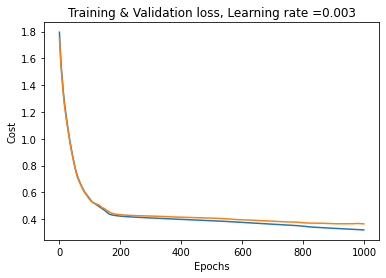

Accuracy: 0.8356545961002786


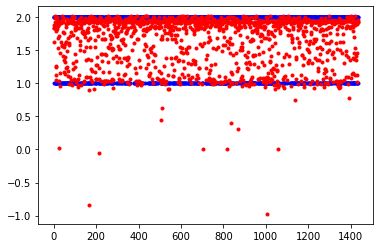

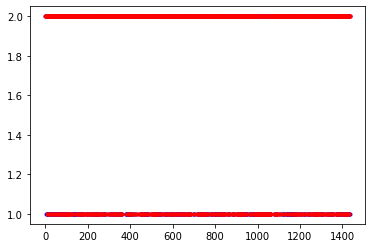

Creating train/test dataset using: SVD_ENTROPY
(4594, 14) (4594,)
(1436, 14) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 2.359045, Validation cost: 2.298867
Epoch 20, Train cost: 1.426067, Validation cost: 1.365155
Epoch 40, Train cost: 0.978239, Validation cost: 0.964876
Epoch 60, Train cost: 0.716580, Validation cost: 0.708848
Epoch 80, Train cost: 0.563795, Validation cost: 0.572884
Epoch 100, Train cost: 0.492742, Validation cost: 0.501633
Epoch 120, Train cost: 0.454307, Validation cost: 0.461468
Epoch 140, Train cost: 0.430818, Validation cost: 0.444093
Epoch 160, Train cost: 0.413995, Validation cost: 0.432698
Epoch 180, Train cost: 0.401346, Validation cost: 0.424304
Epoch 200, Train cost: 0.391625, Validation cost: 0.419632
Epoch 220, Train cost: 0.383934, Validation cost: 0.415375
Epoch 240, Train cost: 0.377110, Validation cost: 0.411865
Epoch 260, Train cost: 0.369885, Validation cost: 0.410120
Epoch 280, Train cost: 0.362428, Validation cost: 0.409790
Epoch 300, Train cost: 0.354107, Validation cost: 0.408479
Epoch 320, Train cost: 0.348275, Validation cost: 0.405039
Epo

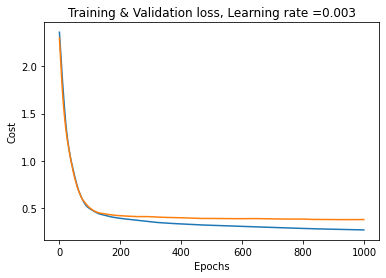

Accuracy: 0.8231197771587744


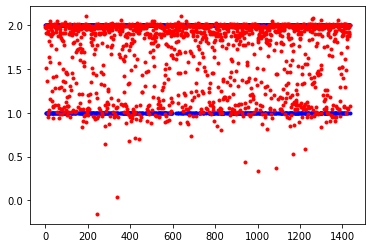

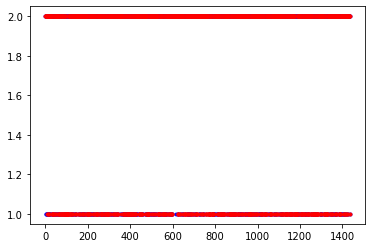

Creating train/test dataset using: APP_ENTROPY
(4594, 14) (4594,)
(1436, 14) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 2.507414, Validation cost: 2.525887
Epoch 20, Train cost: 1.572426, Validation cost: 1.564909
Epoch 40, Train cost: 1.069509, Validation cost: 1.043226
Epoch 60, Train cost: 0.721050, Validation cost: 0.714417
Epoch 80, Train cost: 0.565533, Validation cost: 0.556309
Epoch 100, Train cost: 0.506545, Validation cost: 0.502880
Epoch 120, Train cost: 0.482007, Validation cost: 0.483913
Epoch 140, Train cost: 0.471915, Validation cost: 0.475275
Epoch 160, Train cost: 0.465850, Validation cost: 0.470172
Epoch 180, Train cost: 0.459882, Validation cost: 0.465738
Epoch 200, Train cost: 0.453577, Validation cost: 0.462126
Epoch 220, Train cost: 0.448102, Validation cost: 0.458437
Epoch 240, Train cost: 0.442843, Validation cost: 0.454892
Epoch 260, Train cost: 0.436811, Validation cost: 0.452180
Epoch 280, Train cost: 0.430076, Validation cost: 0.449600
Epoch 300, Train cost: 0.423024, Validation cost: 0.447271
Epoch 320, Train cost: 0.416471, Validation cost: 0.443184
Epo

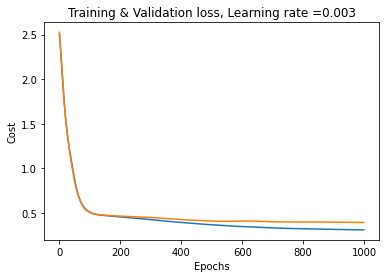

Accuracy: 0.8043175487465181


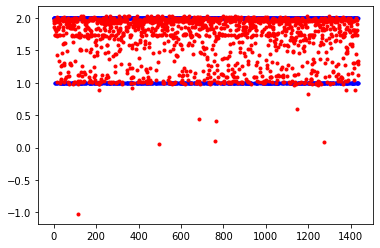

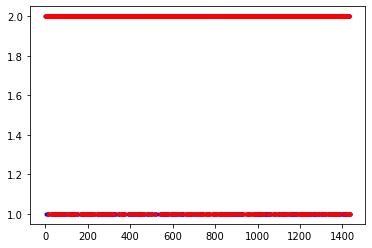

Creating train/test dataset using: NUM_ZEROCROSS
(4594, 14) (4594,)
(1436, 14) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 2.114351, Validation cost: 2.058556
Epoch 20, Train cost: 1.361711, Validation cost: 1.361434
Epoch 40, Train cost: 1.032455, Validation cost: 1.002182
Epoch 60, Train cost: 0.712231, Validation cost: 0.706598
Epoch 80, Train cost: 0.525156, Validation cost: 0.532915
Epoch 100, Train cost: 0.468197, Validation cost: 0.471070
Epoch 120, Train cost: 0.448998, Validation cost: 0.456277
Epoch 140, Train cost: 0.439809, Validation cost: 0.446845
Epoch 160, Train cost: 0.430707, Validation cost: 0.441694
Epoch 180, Train cost: 0.420601, Validation cost: 0.432564
Epoch 200, Train cost: 0.408299, Validation cost: 0.424631
Epoch 220, Train cost: 0.396403, Validation cost: 0.414868
Epoch 240, Train cost: 0.386460, Validation cost: 0.406667
Epoch 260, Train cost: 0.377200, Validation cost: 0.400366
Epoch 280, Train cost: 0.369639, Validation cost: 0.397057
Epoch 300, Train cost: 0.361833, Validation cost: 0.391052
Epoch 320, Train cost: 0.354394, Validation cost: 0.386906
Epo

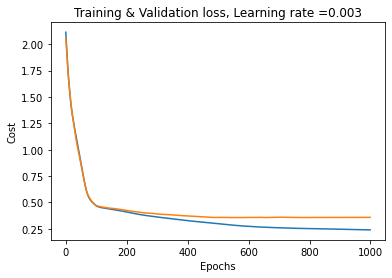

Accuracy: 0.8614206128133705


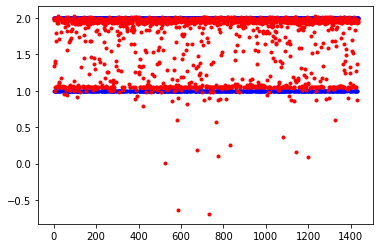

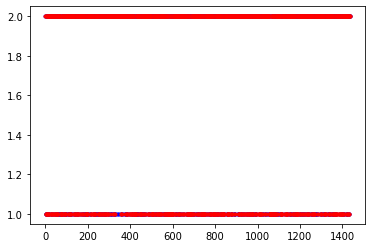

Creating train/test dataset using: PETROSIAN_FD
(4594, 14) (4594,)
(1436, 14) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.450491, Validation cost: 1.436299
Epoch 20, Train cost: 0.963181, Validation cost: 0.968185
Epoch 40, Train cost: 0.781135, Validation cost: 0.791995
Epoch 60, Train cost: 0.657237, Validation cost: 0.662468
Epoch 80, Train cost: 0.564271, Validation cost: 0.571026
Epoch 100, Train cost: 0.491405, Validation cost: 0.499507
Epoch 120, Train cost: 0.452361, Validation cost: 0.465924
Epoch 140, Train cost: 0.438747, Validation cost: 0.451459
Epoch 160, Train cost: 0.430607, Validation cost: 0.439841
Epoch 180, Train cost: 0.422123, Validation cost: 0.429757
Epoch 200, Train cost: 0.412233, Validation cost: 0.424084
Epoch 220, Train cost: 0.402036, Validation cost: 0.414224
Epoch 240, Train cost: 0.391445, Validation cost: 0.403515
Epoch 260, Train cost: 0.380567, Validation cost: 0.390835
Epoch 280, Train cost: 0.370604, Validation cost: 0.385653
Epoch 300, Train cost: 0.361750, Validation cost: 0.381923
Epoch 320, Train cost: 0.354843, Validation cost: 0.377985
Epo

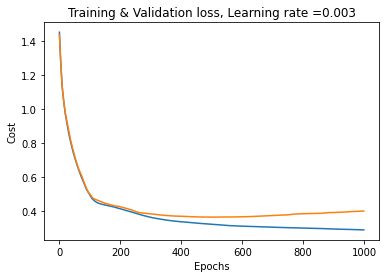

Accuracy: 0.841225626740947


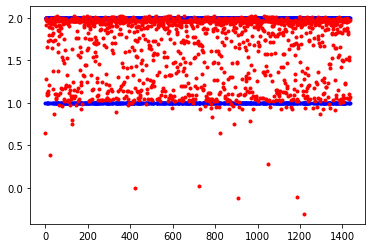

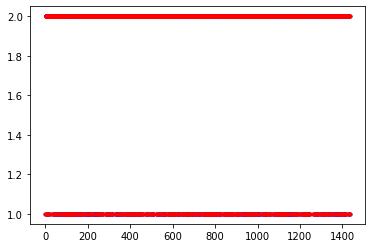

Creating train/test dataset using: KATZ_FD
(4594, 14) (4594,)
(1436, 14) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.483006, Validation cost: 1.522859
Epoch 20, Train cost: 1.041519, Validation cost: 1.098093
Epoch 40, Train cost: 0.802231, Validation cost: 0.839700
Epoch 60, Train cost: 0.605469, Validation cost: 0.613505
Epoch 80, Train cost: 0.497995, Validation cost: 0.504018
Epoch 100, Train cost: 0.468019, Validation cost: 0.474787
Epoch 120, Train cost: 0.455462, Validation cost: 0.467860
Epoch 140, Train cost: 0.444859, Validation cost: 0.467379
Epoch 160, Train cost: 0.434647, Validation cost: 0.461703
Epoch 180, Train cost: 0.426104, Validation cost: 0.453360
Epoch 200, Train cost: 0.419002, Validation cost: 0.447272
Epoch 220, Train cost: 0.412744, Validation cost: 0.438112
Epoch 240, Train cost: 0.406879, Validation cost: 0.433840
Epoch 260, Train cost: 0.401633, Validation cost: 0.433040
Epoch 280, Train cost: 0.395921, Validation cost: 0.434977
Epoch 300, Train cost: 0.389715, Validation cost: 0.433464
Epoch 320, Train cost: 0.383997, Validation cost: 0.431889
Epo

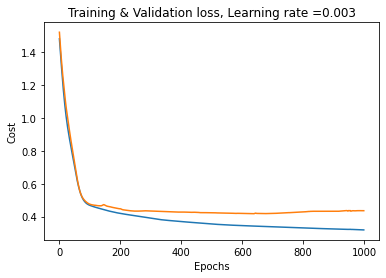

Accuracy: 0.7520891364902507


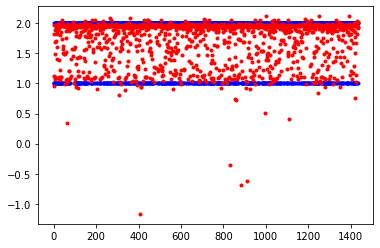

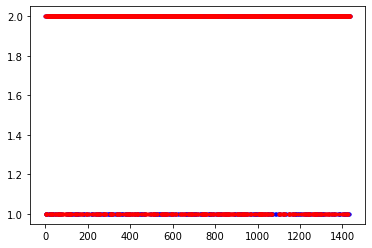

Creating train/test dataset using: HIGUCHI_FD
(4594, 14) (4594,)
(1436, 14) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.706605, Validation cost: 1.672687
Epoch 20, Train cost: 1.020679, Validation cost: 0.968138
Epoch 40, Train cost: 0.697852, Validation cost: 0.708321
Epoch 60, Train cost: 0.566228, Validation cost: 0.588427
Epoch 80, Train cost: 0.518099, Validation cost: 0.533191
Epoch 100, Train cost: 0.493274, Validation cost: 0.510750
Epoch 120, Train cost: 0.480871, Validation cost: 0.493414
Epoch 140, Train cost: 0.469453, Validation cost: 0.482783
Epoch 160, Train cost: 0.455410, Validation cost: 0.471282
Epoch 180, Train cost: 0.445597, Validation cost: 0.456832
Epoch 200, Train cost: 0.437458, Validation cost: 0.445445
Epoch 220, Train cost: 0.427278, Validation cost: 0.437083
Epoch 240, Train cost: 0.421966, Validation cost: 0.433871
Epoch 260, Train cost: 0.417813, Validation cost: 0.431406
Epoch 280, Train cost: 0.414404, Validation cost: 0.427824
Epoch 300, Train cost: 0.410322, Validation cost: 0.423830
Epoch 320, Train cost: 0.405250, Validation cost: 0.419920
Epo

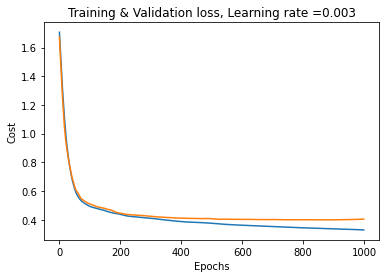

Accuracy: 0.8091922005571031


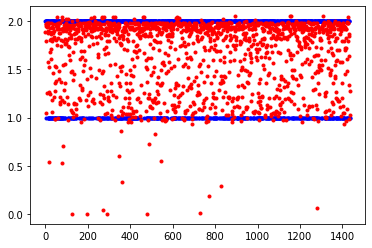

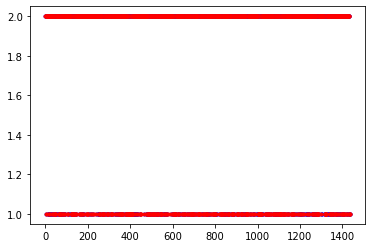

In [184]:
for i in range(7):
  x_train_, x_test_, y_train_, y_test_, x_val_, y_val_ = create_feature_dataset(i)
  x_train_ = np.nan_to_num(x_train_, copy=True, nan=0.0, posinf=None, neginf=None)
  x_test_ = np.nan_to_num(x_test_, copy=True, nan=0.0, posinf=None, neginf=None)
  x_val_ = np.nan_to_num(x_val_, copy=True, nan=0.0, posinf=None, neginf=None)

  x_train_ = scale_std(x_train_)
  x_val_ = scale_std(x_val_)
  x_test_ = scale_std(x_test_)

  m = 100  
  alpha = 3e-3 
  num_epochs = 1000

  data = [x_train_, y_train_, x_test_, y_test_]
  fis, final_loss = train_anfis(data, x_train_.shape[1], m, alpha, num_epochs, True)

In [185]:
print(features)

['perm_entropy', 'svd_entropy', 'app_entropy', 'num_zerocross', 'petrosian_fd', 'katz_fd', 'higuchi_fd']


(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.713588, Validation cost: 1.714050
Epoch 20, Train cost: 1.569682, Validation cost: 1.567139
Epoch 40, Train cost: 1.307341, Validation cost: 1.293365
Epoch 60, Train cost: 1.041403, Validation cost: 1.026641
Epoch 80, Train cost: 0.803837, Validation cost: 0.803599
Epoch 100, Train cost: 0.660601, Validation cost: 0.655796
Epoch 120, Train cost: 0.549276, Validation cost: 0.550518
Epoch 140, Train cost: 0.476169, Validation cost: 0.490447
Epoch 160, Train cost: 0.441253, Validation cost: 0.466686
Epoch 180, Train cost: 0.418036, Validation cost: 0.441926
Epoch 200, Train cost: 0.401491, Validation cost: 0.426825
Epoch 220, Train cost: 0.385952, Validation cost: 0.416354
Epoch 240, Train cost: 0.370896, Validation cost: 0.407088
Epoch 260, Train cost: 0.359468, Validation cost: 0.397975
Epoch 280, Train cost: 0.346868, Validation cost: 0.390860
Epoch 300, Train cost: 0.335700, Validation cost: 0.384950
Epoch 320, Train cost: 0.326646, Validation cost: 0.378694
Epo

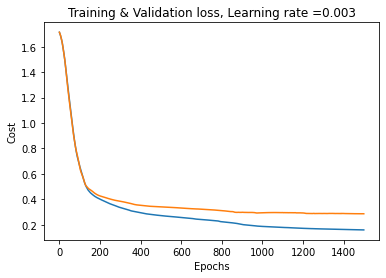

Accuracy: 0.9178272980501393


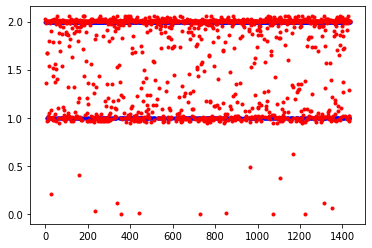

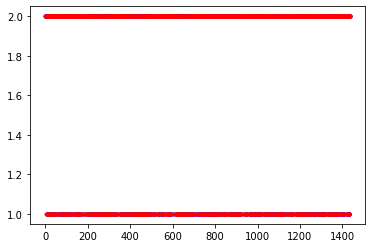

In [194]:
x_train_, x_test_, y_train_, y_test_, x_val_, y_val_ = create_feature_dataset([0,3])
x_train_ = np.nan_to_num(x_train_, copy=True, nan=0.0, posinf=None, neginf=None)
x_test_ = np.nan_to_num(x_test_, copy=True, nan=0.0, posinf=None, neginf=None)
x_val_ = np.nan_to_num(x_val_, copy=True, nan=0.0, posinf=None, neginf=None)

x_train_ = scale_std(x_train_)
x_val_ = scale_std(x_val_)
x_test_ = scale_std(x_test_)

m = 200  
alpha = 3e-3 
num_epochs = 1500

data = [x_train_, y_train_, x_test_, y_test_]
fis, final_loss = train_anfis(data, x_train_.shape[1], m, alpha, num_epochs, True)

RULES: 119
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.740974, Validation cost: 1.745787
Epoch 20, Train cost: 1.714778, Validation cost: 1.718089
Epoch 40, Train cost: 1.538573, Validation cost: 1.533110
Epoch 60, Train cost: 1.109052, Validation cost: 1.102552
Epoch 80, Train cost: 0.805458, Validation cost: 0.803440



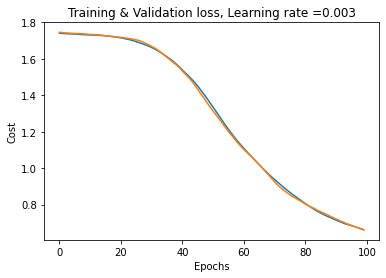

Accuracy: 0.6824512534818942


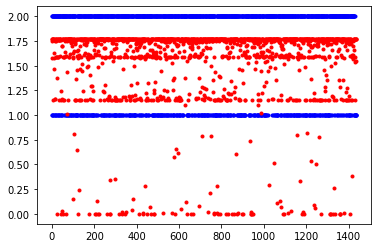

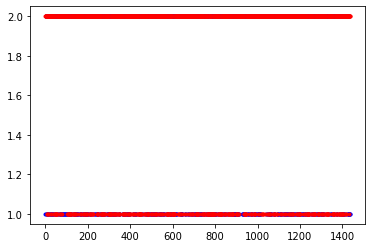

RULES: 207
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.751158, Validation cost: 1.753860
Epoch 20, Train cost: 1.690391, Validation cost: 1.687450
Epoch 40, Train cost: 1.407377, Validation cost: 1.392211
Epoch 60, Train cost: 1.094555, Validation cost: 1.093151
Epoch 80, Train cost: 0.933808, Validation cost: 0.937162



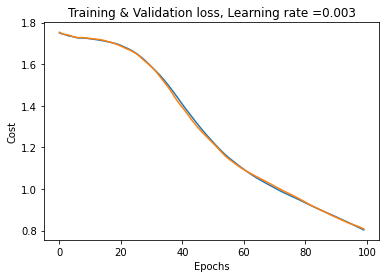

Accuracy: 0.44220055710306405


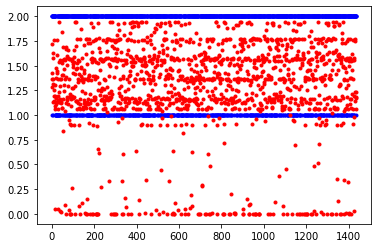

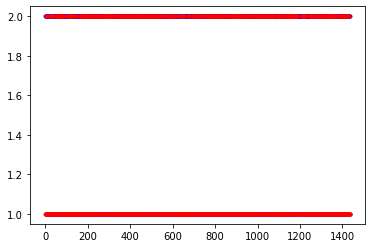

RULES: 282
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.830126, Validation cost: 1.817983
Epoch 20, Train cost: 1.543683, Validation cost: 1.533579
Epoch 40, Train cost: 1.285698, Validation cost: 1.260734
Epoch 60, Train cost: 1.003482, Validation cost: 0.989178
Epoch 80, Train cost: 0.788355, Validation cost: 0.783996



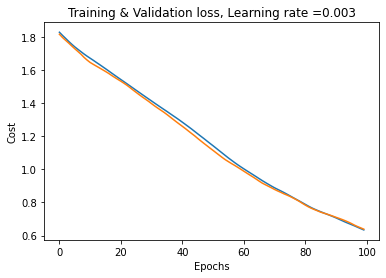

Accuracy: 0.5779944289693594


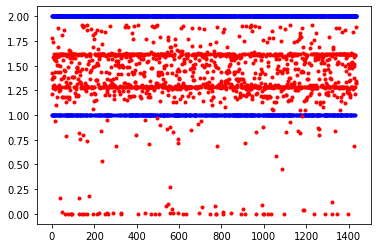

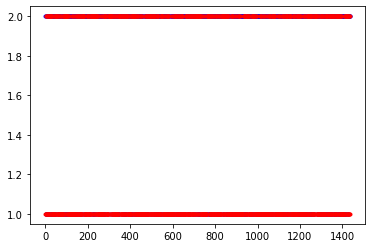

RULES: 136
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.741990, Validation cost: 1.740030
Epoch 20, Train cost: 1.674183, Validation cost: 1.663268
Epoch 40, Train cost: 1.348078, Validation cost: 1.324921
Epoch 60, Train cost: 1.000039, Validation cost: 0.981354
Epoch 80, Train cost: 0.786318, Validation cost: 0.808216



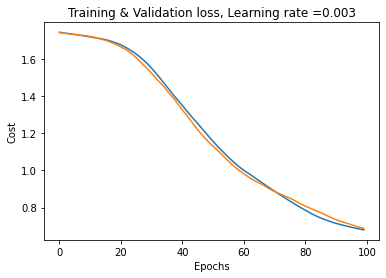

Accuracy: 0.6511142061281338


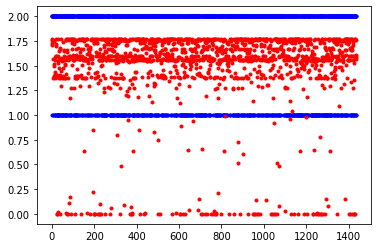

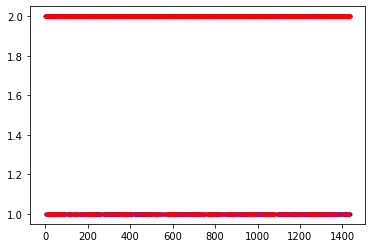

RULES: 235
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.755723, Validation cost: 1.739114
Epoch 20, Train cost: 1.609313, Validation cost: 1.593568
Epoch 40, Train cost: 1.283410, Validation cost: 1.257421
Epoch 60, Train cost: 0.912029, Validation cost: 0.896636
Epoch 80, Train cost: 0.694958, Validation cost: 0.691073



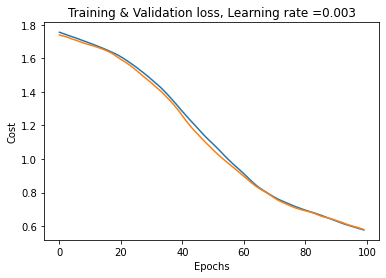

Accuracy: 0.6274373259052924


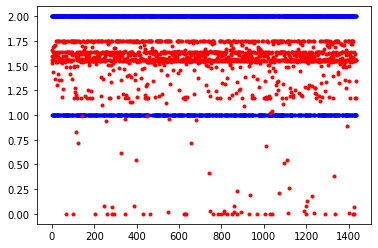

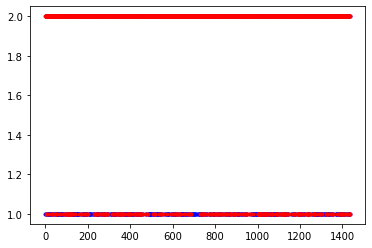

RULES: 83
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.676404, Validation cost: 1.672352
Epoch 20, Train cost: 1.498908, Validation cost: 1.493790
Epoch 40, Train cost: 1.294541, Validation cost: 1.283830
Epoch 60, Train cost: 1.091849, Validation cost: 1.093387
Epoch 80, Train cost: 0.941901, Validation cost: 0.936632



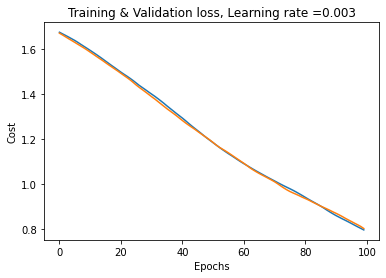

Accuracy: 0.43941504178272983


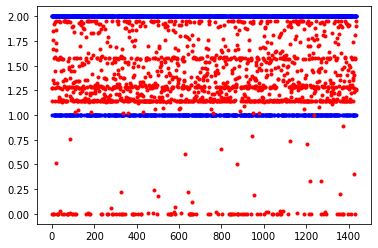

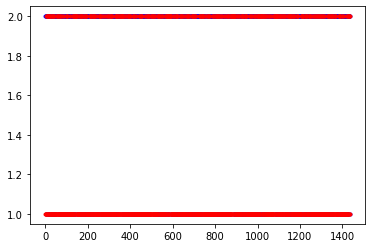

RULES: 163
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.690987, Validation cost: 1.697189
Epoch 20, Train cost: 1.498654, Validation cost: 1.501154
Epoch 40, Train cost: 1.181393, Validation cost: 1.166341
Epoch 60, Train cost: 0.895638, Validation cost: 0.884203
Epoch 80, Train cost: 0.686211, Validation cost: 0.670462



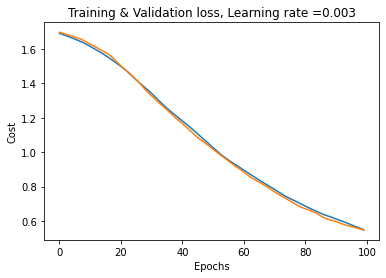

Accuracy: 0.6552924791086351


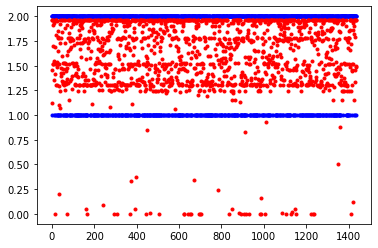

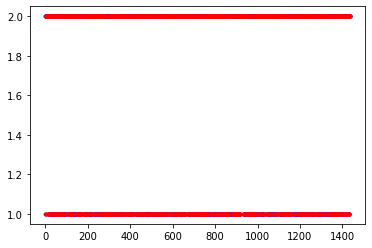

RULES: 208
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.801803, Validation cost: 1.811946
Epoch 20, Train cost: 1.562928, Validation cost: 1.551877
Epoch 40, Train cost: 1.261615, Validation cost: 1.259350
Epoch 60, Train cost: 0.994633, Validation cost: 0.992177
Epoch 80, Train cost: 0.789099, Validation cost: 0.789807



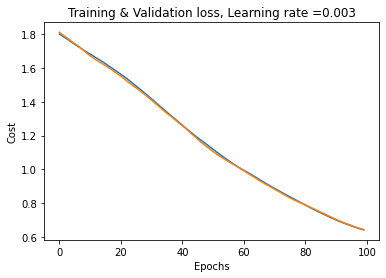

Accuracy: 0.5724233983286908


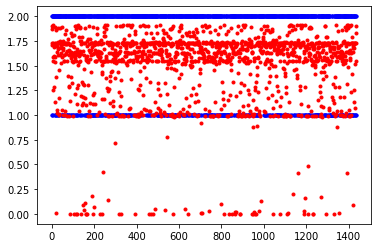

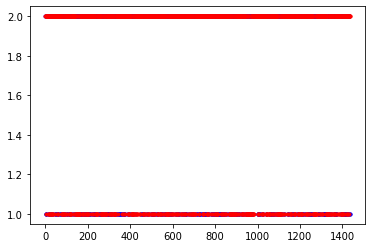

RULES: 137
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.721904, Validation cost: 1.721506
Epoch 20, Train cost: 1.591832, Validation cost: 1.596360
Epoch 40, Train cost: 1.352414, Validation cost: 1.359701
Epoch 60, Train cost: 1.166256, Validation cost: 1.164146
Epoch 80, Train cost: 0.960049, Validation cost: 0.950185



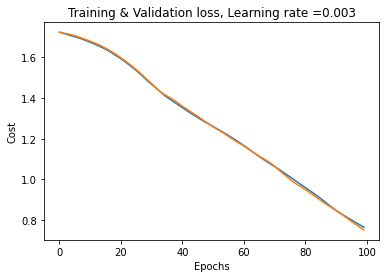

Accuracy: 0.3774373259052925


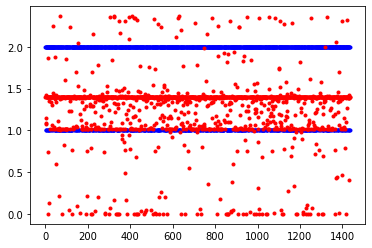

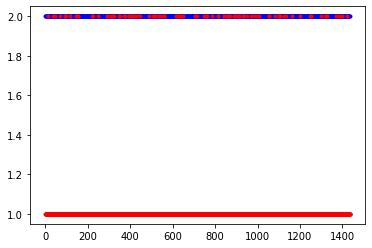

RULES: 269
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.740000, Validation cost: 1.742087
Epoch 20, Train cost: 1.646057, Validation cost: 1.633195
Epoch 40, Train cost: 1.389523, Validation cost: 1.370155
Epoch 60, Train cost: 1.054008, Validation cost: 1.047127
Epoch 80, Train cost: 0.785486, Validation cost: 0.783733



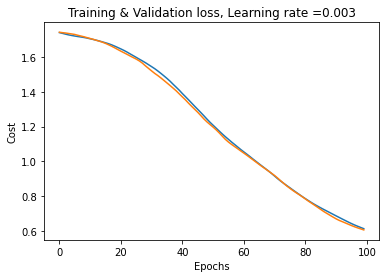

Accuracy: 0.4596100278551532


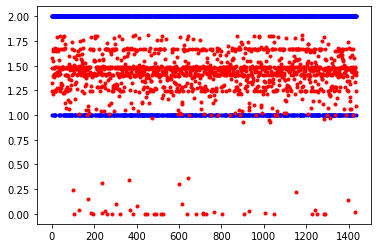

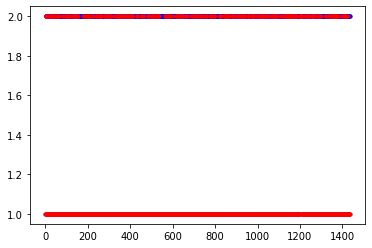

RULES: 222
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.793604, Validation cost: 1.793370
Epoch 20, Train cost: 1.688572, Validation cost: 1.680588
Epoch 40, Train cost: 1.358123, Validation cost: 1.327806
Epoch 60, Train cost: 1.024932, Validation cost: 1.007543
Epoch 80, Train cost: 0.814543, Validation cost: 0.820437



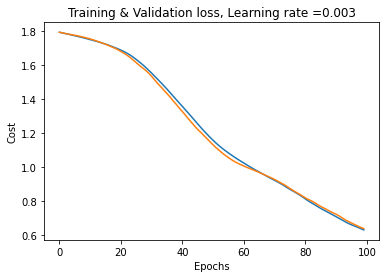

Accuracy: 0.552924791086351


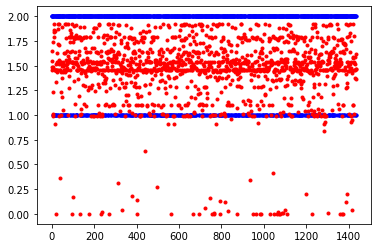

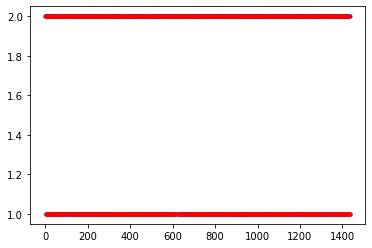

RULES: 230
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.752378, Validation cost: 1.748994
Epoch 20, Train cost: 1.537267, Validation cost: 1.546698
Epoch 40, Train cost: 1.238448, Validation cost: 1.216296
Epoch 60, Train cost: 0.964487, Validation cost: 0.943583
Epoch 80, Train cost: 0.772588, Validation cost: 0.764760



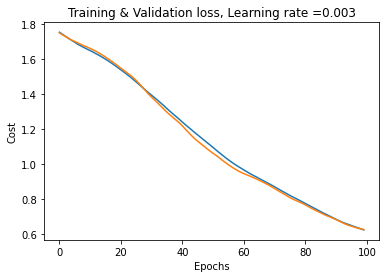

Accuracy: 0.653899721448468


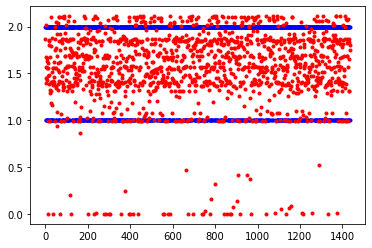

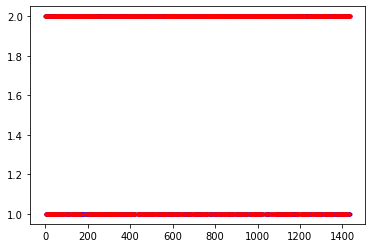

RULES: 52
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.738353, Validation cost: 1.741225
Epoch 20, Train cost: 1.708514, Validation cost: 1.710814
Epoch 40, Train cost: 1.559330, Validation cost: 1.555871
Epoch 60, Train cost: 1.216935, Validation cost: 1.187470
Epoch 80, Train cost: 0.919001, Validation cost: 0.912629



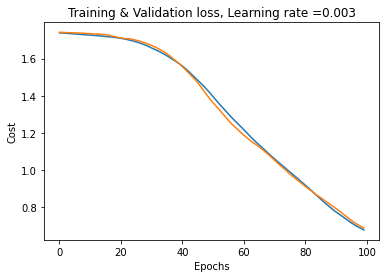

Accuracy: 0.6232590529247911


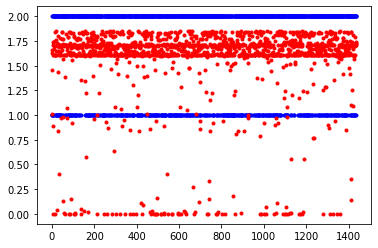

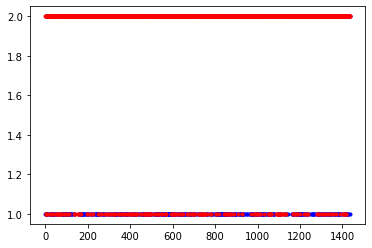

RULES: 233
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.683112, Validation cost: 1.681801
Epoch 20, Train cost: 1.493541, Validation cost: 1.482904
Epoch 40, Train cost: 1.260784, Validation cost: 1.262771
Epoch 60, Train cost: 0.989209, Validation cost: 0.985234
Epoch 80, Train cost: 0.759089, Validation cost: 0.757719



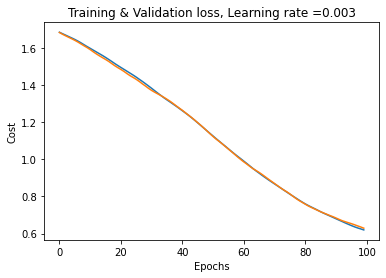

Accuracy: 0.5383008356545961


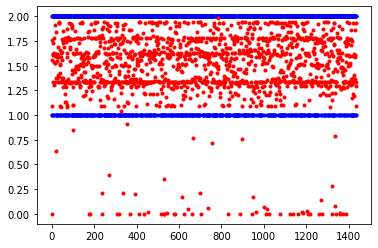

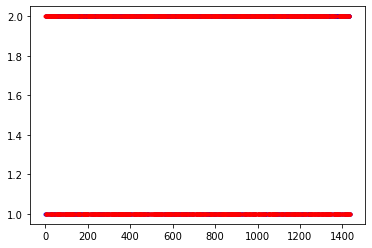

RULES: 43
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.729449, Validation cost: 1.732192
Epoch 20, Train cost: 1.720341, Validation cost: 1.721756
Epoch 40, Train cost: 1.646380, Validation cost: 1.636276
Epoch 60, Train cost: 1.447103, Validation cost: 1.431017
Epoch 80, Train cost: 1.222920, Validation cost: 1.205310



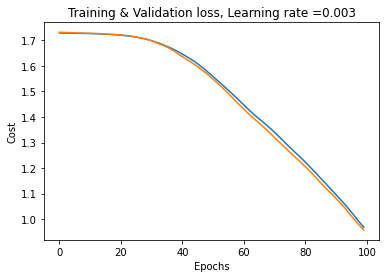

Accuracy: 0.4352367688022284


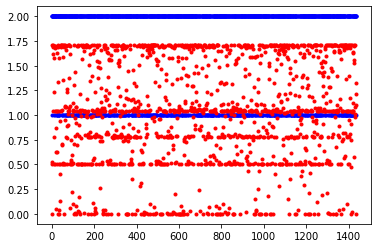

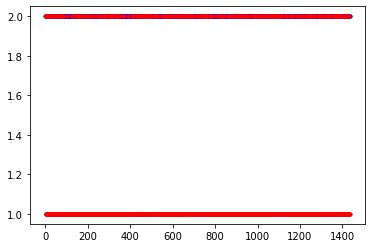

RULES: 118
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.820614, Validation cost: 1.822489
Epoch 20, Train cost: 1.716456, Validation cost: 1.716770
Epoch 40, Train cost: 1.577801, Validation cost: 1.573450
Epoch 60, Train cost: 1.211350, Validation cost: 1.200534
Epoch 80, Train cost: 0.872621, Validation cost: 0.884840



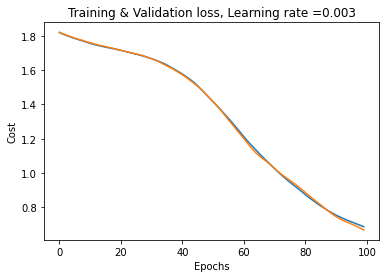

Accuracy: 0.6142061281337048


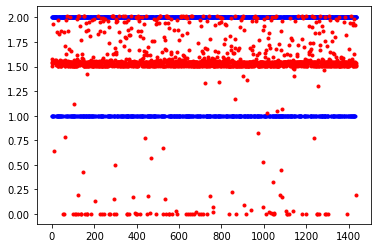

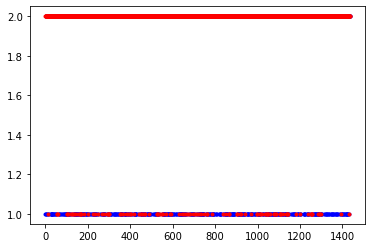

RULES: 187
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.725925, Validation cost: 1.733444
Epoch 20, Train cost: 1.661049, Validation cost: 1.655771
Epoch 40, Train cost: 1.387261, Validation cost: 1.350719
Epoch 60, Train cost: 1.035295, Validation cost: 1.036386
Epoch 80, Train cost: 0.837638, Validation cost: 0.843298



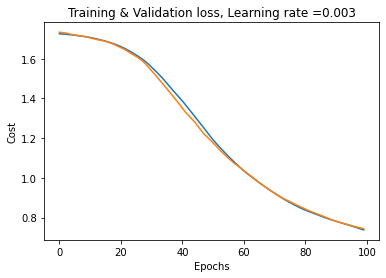

Accuracy: 0.334958217270195


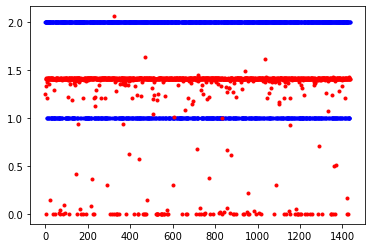

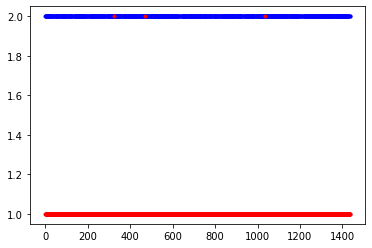

RULES: 253
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.717297, Validation cost: 1.709279
Epoch 20, Train cost: 1.546944, Validation cost: 1.530274
Epoch 40, Train cost: 1.126657, Validation cost: 1.096865
Epoch 60, Train cost: 0.829134, Validation cost: 0.818505
Epoch 80, Train cost: 0.627675, Validation cost: 0.647576



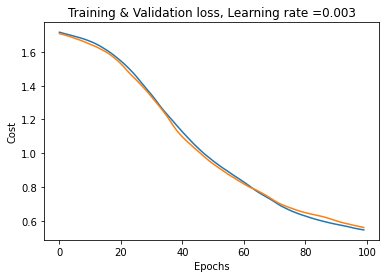

Accuracy: 0.6824512534818942


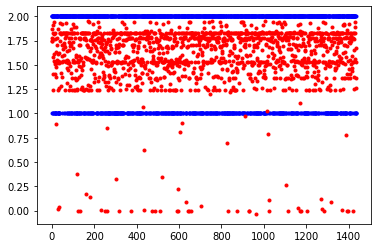

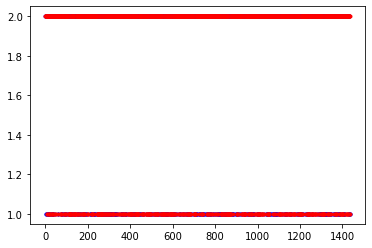

RULES: 161
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 2.148042, Validation cost: 2.148729
Epoch 20, Train cost: 1.665066, Validation cost: 1.653392
Epoch 40, Train cost: 1.401799, Validation cost: 1.401479
Epoch 60, Train cost: 1.182645, Validation cost: 1.174926
Epoch 80, Train cost: 0.972783, Validation cost: 0.960024



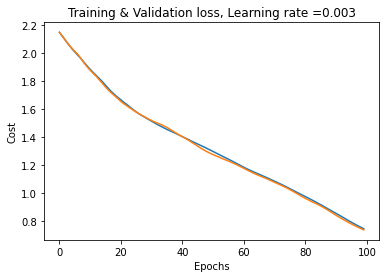

Accuracy: 0.564066852367688


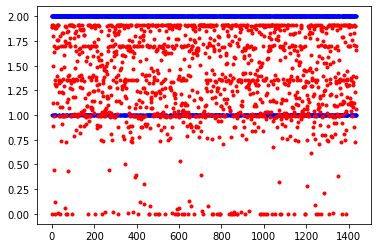

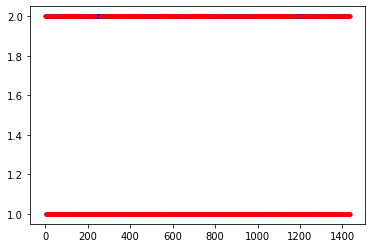

RULES: 192
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.750223, Validation cost: 1.743437
Epoch 20, Train cost: 1.684298, Validation cost: 1.675668
Epoch 40, Train cost: 1.418427, Validation cost: 1.384954
Epoch 60, Train cost: 1.061603, Validation cost: 1.061913
Epoch 80, Train cost: 0.800842, Validation cost: 0.817911



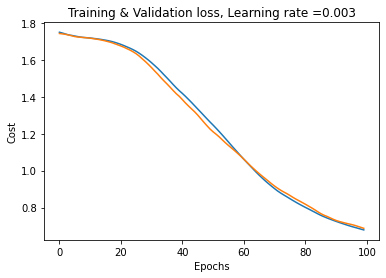

Accuracy: 0.6288300835654597


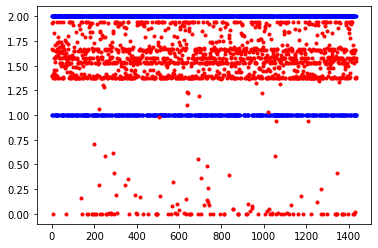

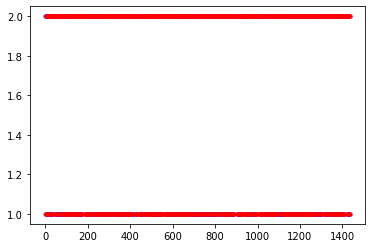

RULES: 90
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.746615, Validation cost: 1.749625
Epoch 20, Train cost: 1.692115, Validation cost: 1.693610
Epoch 40, Train cost: 1.544689, Validation cost: 1.540034
Epoch 60, Train cost: 1.297816, Validation cost: 1.281930
Epoch 80, Train cost: 1.058123, Validation cost: 1.034853



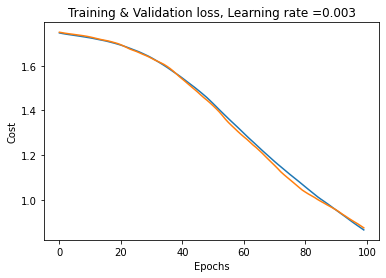

Accuracy: 0.4136490250696379


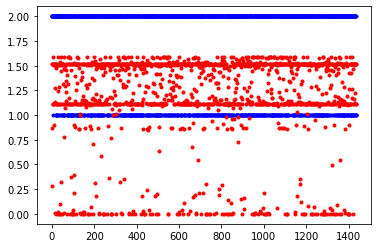

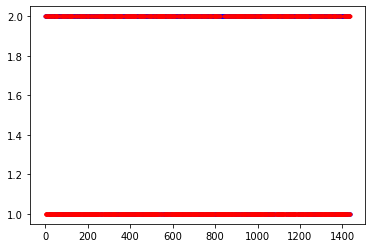

RULES: 41
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.730528, Validation cost: 1.734625
Epoch 20, Train cost: 1.730019, Validation cost: 1.734311
Epoch 40, Train cost: 1.729917, Validation cost: 1.734311
Epoch 60, Train cost: 1.726882, Validation cost: 1.731524
Epoch 80, Train cost: 1.647352, Validation cost: 1.634677



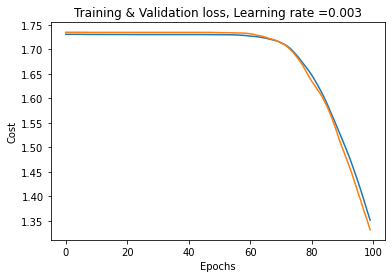

Accuracy: 0.3328690807799443


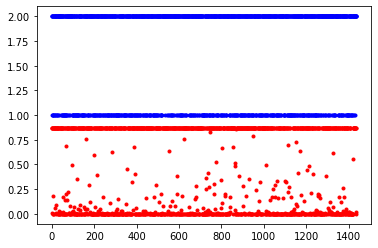

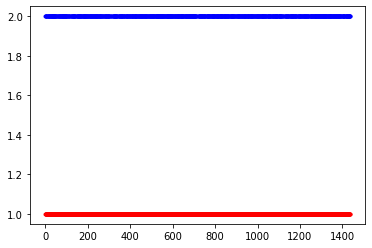

RULES: 203
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 2.131687, Validation cost: 2.137862
Epoch 20, Train cost: 1.802195, Validation cost: 1.801703
Epoch 40, Train cost: 1.614642, Validation cost: 1.609584
Epoch 60, Train cost: 1.291268, Validation cost: 1.279521
Epoch 80, Train cost: 0.908429, Validation cost: 0.893541



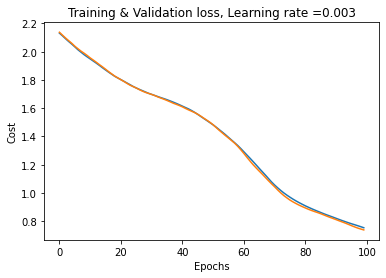

Accuracy: 0.451949860724234


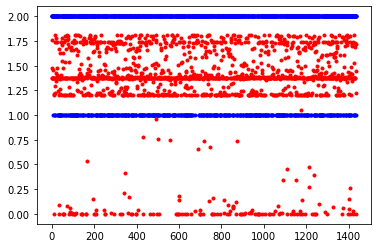

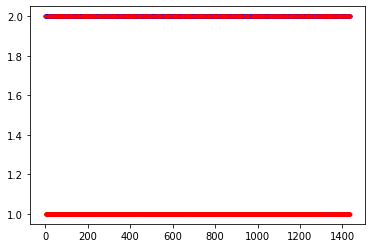

RULES: 109
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.728355, Validation cost: 1.725425
Epoch 20, Train cost: 1.664750, Validation cost: 1.658477
Epoch 40, Train cost: 1.424007, Validation cost: 1.410577
Epoch 60, Train cost: 1.087371, Validation cost: 1.080890
Epoch 80, Train cost: 0.803249, Validation cost: 0.795834



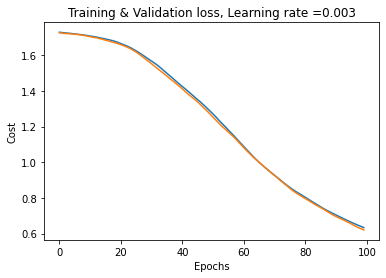

Accuracy: 0.49303621169916434


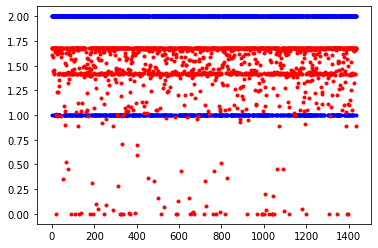

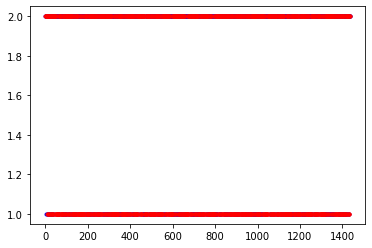

RULES: 116
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.722282, Validation cost: 1.720671
Epoch 20, Train cost: 1.603644, Validation cost: 1.577134
Epoch 40, Train cost: 1.302950, Validation cost: 1.278986
Epoch 60, Train cost: 1.033472, Validation cost: 1.018066
Epoch 80, Train cost: 0.869210, Validation cost: 0.865984



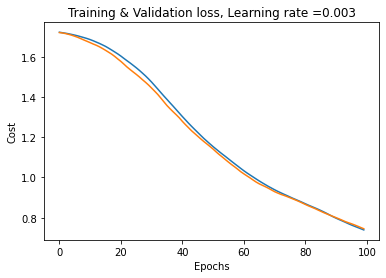

Accuracy: 0.3969359331476323


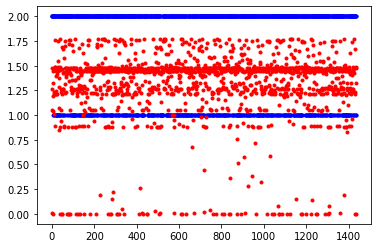

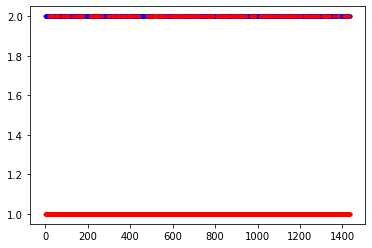

RULES: 82
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.748650, Validation cost: 1.753513
Epoch 20, Train cost: 1.673679, Validation cost: 1.671446
Epoch 40, Train cost: 1.448500, Validation cost: 1.440236
Epoch 60, Train cost: 1.172456, Validation cost: 1.161990
Epoch 80, Train cost: 0.966002, Validation cost: 0.961367



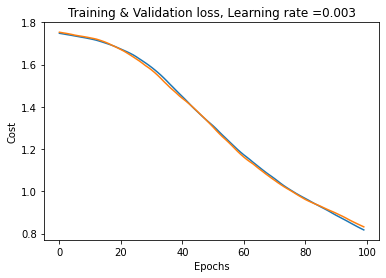

Accuracy: 0.3328690807799443


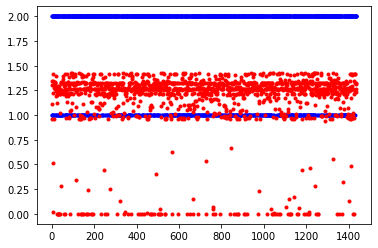

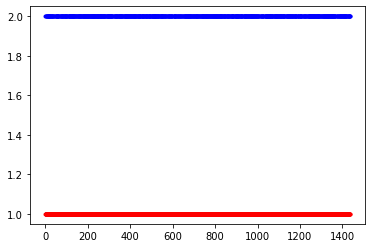

RULES: 256
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.759420, Validation cost: 1.759661
Epoch 20, Train cost: 1.595118, Validation cost: 1.598449
Epoch 40, Train cost: 1.340945, Validation cost: 1.343052
Epoch 60, Train cost: 1.032619, Validation cost: 1.013498
Epoch 80, Train cost: 0.780159, Validation cost: 0.758740



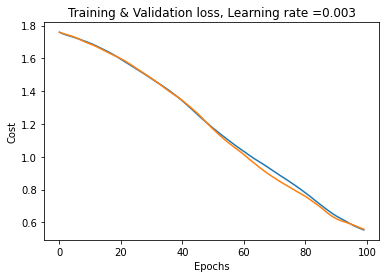

Accuracy: 0.6720055710306406


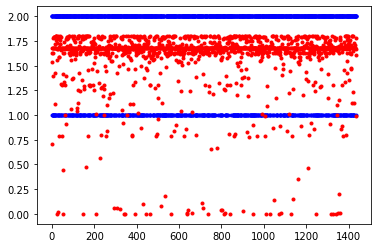

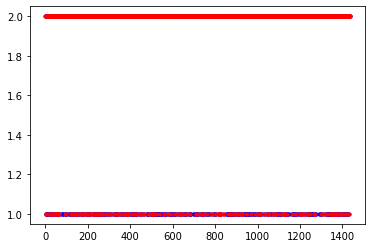

RULES: 224
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.724626, Validation cost: 1.715497
Epoch 20, Train cost: 1.569156, Validation cost: 1.557963
Epoch 40, Train cost: 1.318784, Validation cost: 1.310736
Epoch 60, Train cost: 1.035471, Validation cost: 1.031062
Epoch 80, Train cost: 0.800024, Validation cost: 0.804059



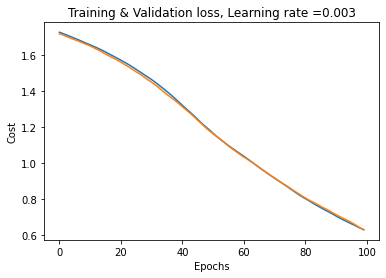

Accuracy: 0.5738161559888579


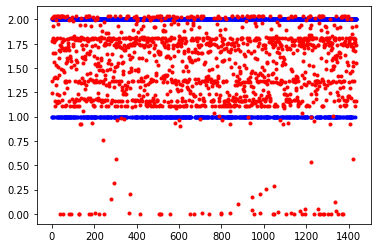

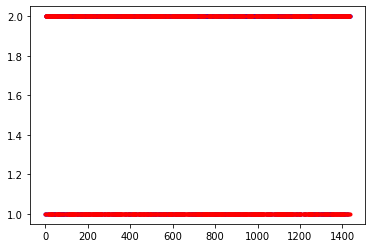

RULES: 76
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.745366, Validation cost: 1.756372
Epoch 20, Train cost: 1.665351, Validation cost: 1.651996
Epoch 40, Train cost: 1.397894, Validation cost: 1.381840
Epoch 60, Train cost: 1.114297, Validation cost: 1.120146
Epoch 80, Train cost: 0.932152, Validation cost: 0.942224



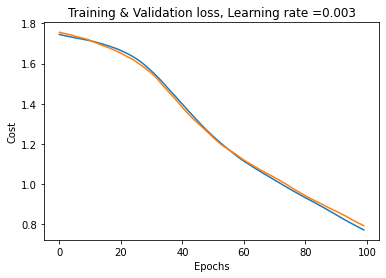

Accuracy: 0.42479108635097496


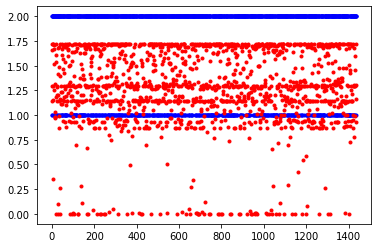

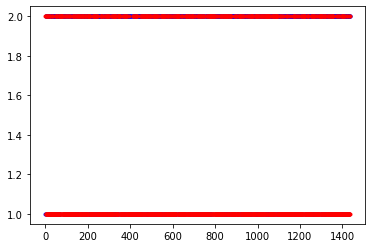

RULES: 89
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.731116, Validation cost: 1.737882
Epoch 20, Train cost: 1.702649, Validation cost: 1.707944
Epoch 40, Train cost: 1.510922, Validation cost: 1.468123
Epoch 60, Train cost: 1.073016, Validation cost: 1.054136
Epoch 80, Train cost: 0.823361, Validation cost: 0.824431



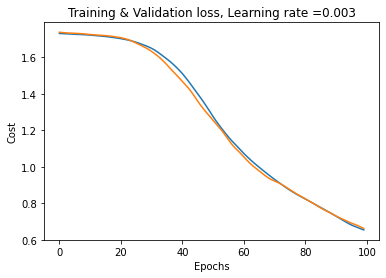

Accuracy: 0.5766016713091922


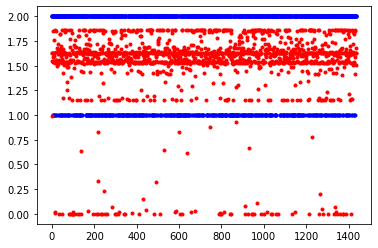

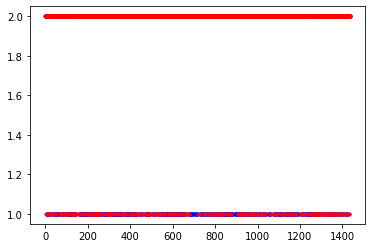

RULES: 268
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.836251, Validation cost: 1.833580
Epoch 20, Train cost: 1.661305, Validation cost: 1.643308
Epoch 40, Train cost: 1.333646, Validation cost: 1.295595
Epoch 60, Train cost: 0.986053, Validation cost: 0.985209
Epoch 80, Train cost: 0.777499, Validation cost: 0.783725



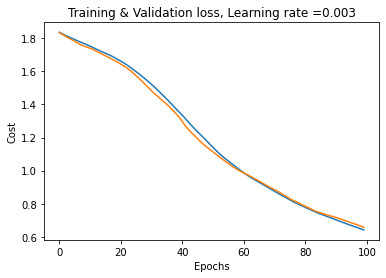

Accuracy: 0.6225626740947076


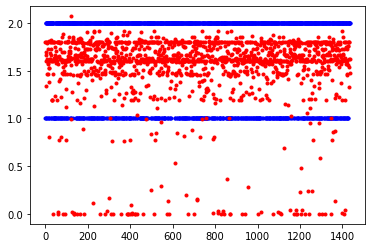

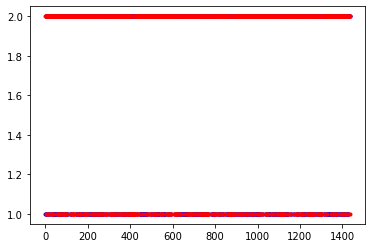

RULES: 108
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.736759, Validation cost: 1.738354
Epoch 20, Train cost: 1.712794, Validation cost: 1.709101
Epoch 40, Train cost: 1.566492, Validation cost: 1.544400
Epoch 60, Train cost: 1.213287, Validation cost: 1.195040
Epoch 80, Train cost: 0.946556, Validation cost: 0.944337



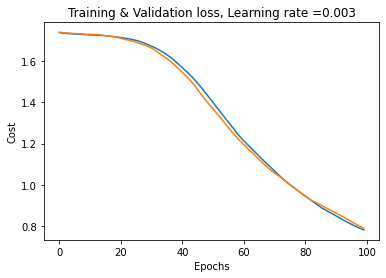

Accuracy: 0.5619777158774373


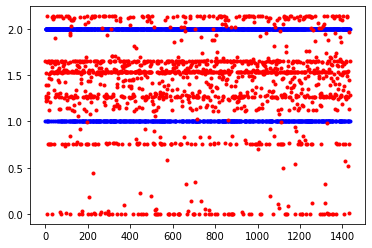

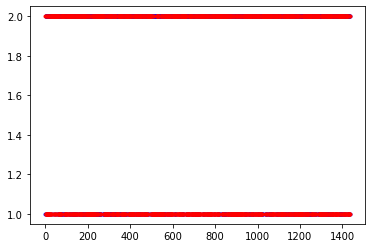

RULES: 54
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.732517, Validation cost: 1.735450
Epoch 20, Train cost: 1.710180, Validation cost: 1.709410
Epoch 40, Train cost: 1.642818, Validation cost: 1.635178
Epoch 60, Train cost: 1.511891, Validation cost: 1.501156
Epoch 80, Train cost: 1.339223, Validation cost: 1.337537



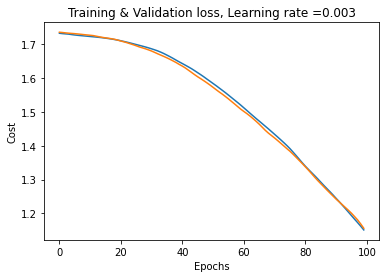

Accuracy: 0.3649025069637883


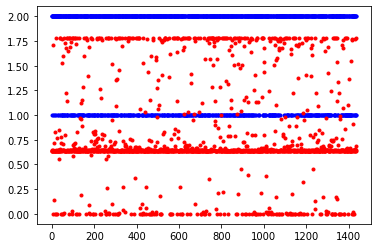

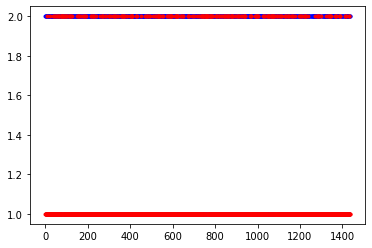

RULES: 184
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.731111, Validation cost: 1.727752
Epoch 20, Train cost: 1.591359, Validation cost: 1.593032
Epoch 40, Train cost: 1.316550, Validation cost: 1.303973
Epoch 60, Train cost: 1.013497, Validation cost: 1.002345
Epoch 80, Train cost: 0.768337, Validation cost: 0.758664



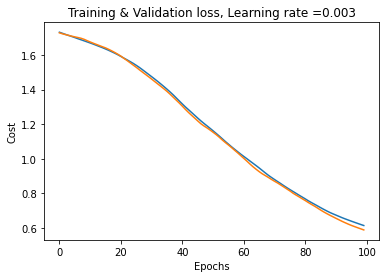

Accuracy: 0.5821727019498607


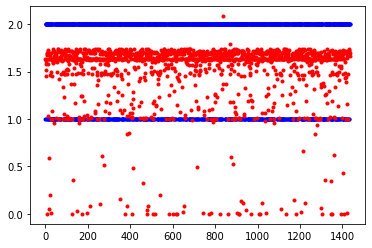

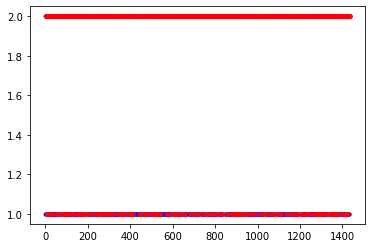

RULES: 86
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.728506, Validation cost: 1.729266
Epoch 20, Train cost: 1.659502, Validation cost: 1.654963
Epoch 40, Train cost: 1.428354, Validation cost: 1.397001
Epoch 60, Train cost: 1.123115, Validation cost: 1.110236
Epoch 80, Train cost: 0.873060, Validation cost: 0.876271



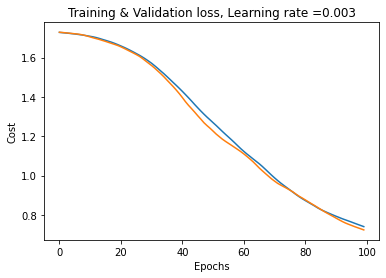

Accuracy: 0.4700557103064067


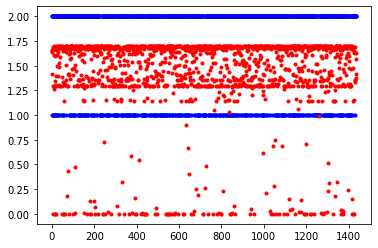

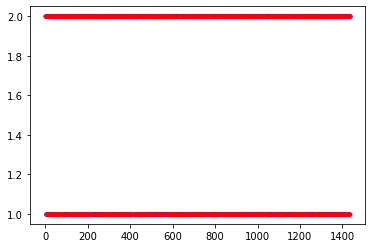

RULES: 183
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.733633, Validation cost: 1.730945
Epoch 20, Train cost: 1.564685, Validation cost: 1.549312
Epoch 40, Train cost: 1.162017, Validation cost: 1.136181
Epoch 60, Train cost: 0.851405, Validation cost: 0.847242
Epoch 80, Train cost: 0.675545, Validation cost: 0.684939



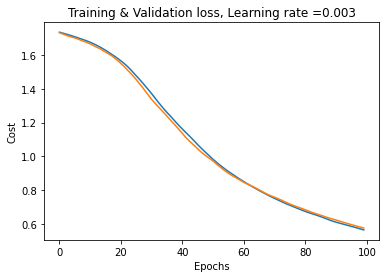

Accuracy: 0.6671309192200557


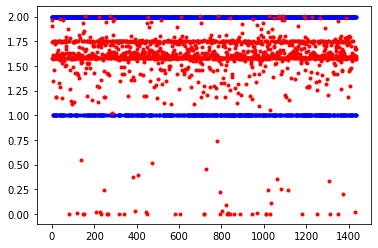

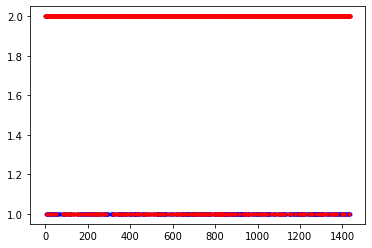

RULES: 110
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.722976, Validation cost: 1.726361
Epoch 20, Train cost: 1.610745, Validation cost: 1.602463
Epoch 40, Train cost: 1.285911, Validation cost: 1.278152
Epoch 60, Train cost: 1.022490, Validation cost: 1.012919
Epoch 80, Train cost: 0.869817, Validation cost: 0.842262



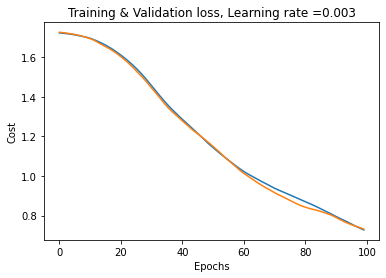

Accuracy: 0.5933147632311978


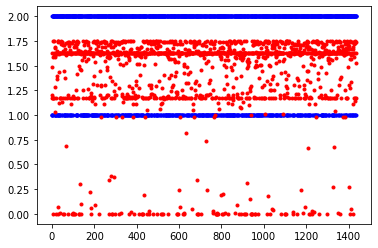

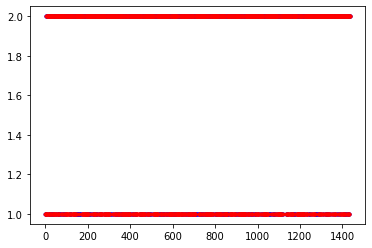

RULES: 262
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.785637, Validation cost: 1.785951
Epoch 20, Train cost: 1.678000, Validation cost: 1.674310
Epoch 40, Train cost: 1.393102, Validation cost: 1.367380
Epoch 60, Train cost: 1.025495, Validation cost: 1.004575
Epoch 80, Train cost: 0.743762, Validation cost: 0.741249



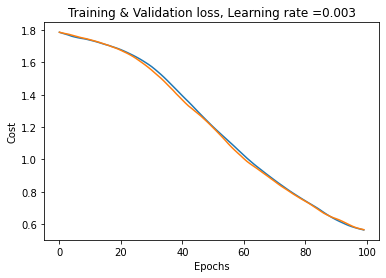

Accuracy: 0.6497214484679665


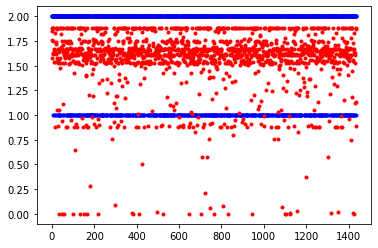

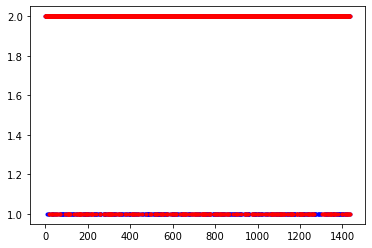

RULES: 119
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.727666, Validation cost: 1.732501
Epoch 20, Train cost: 1.704102, Validation cost: 1.705046
Epoch 40, Train cost: 1.546643, Validation cost: 1.534030
Epoch 60, Train cost: 1.188420, Validation cost: 1.158194
Epoch 80, Train cost: 0.885509, Validation cost: 0.867108



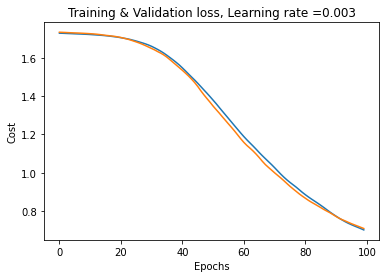

Accuracy: 0.600974930362117


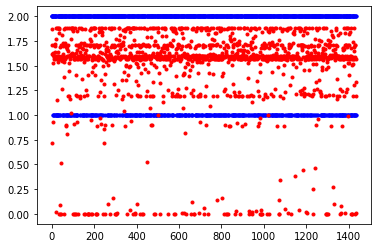

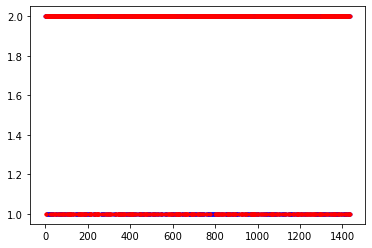

RULES: 167
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.735213, Validation cost: 1.734362
Epoch 20, Train cost: 1.651539, Validation cost: 1.646906
Epoch 40, Train cost: 1.350400, Validation cost: 1.334370
Epoch 60, Train cost: 0.933178, Validation cost: 0.901810
Epoch 80, Train cost: 0.690581, Validation cost: 0.685013



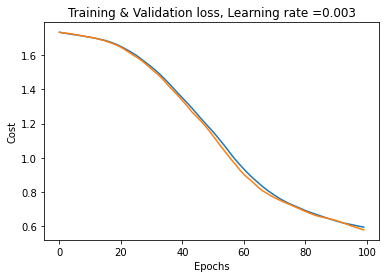

Accuracy: 0.6162952646239555


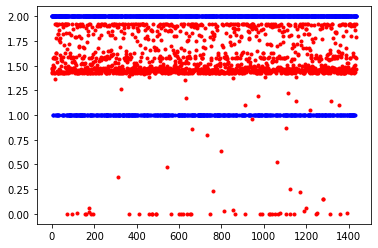

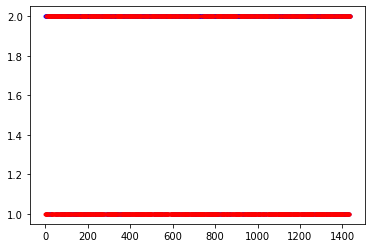

RULES: 220
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.722507, Validation cost: 1.715966
Epoch 20, Train cost: 1.563706, Validation cost: 1.561633
Epoch 40, Train cost: 1.373520, Validation cost: 1.378187
Epoch 60, Train cost: 1.190036, Validation cost: 1.201981
Epoch 80, Train cost: 0.938546, Validation cost: 0.930657



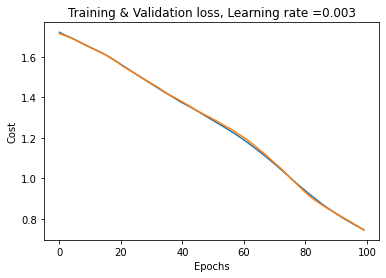

Accuracy: 0.37047353760445684


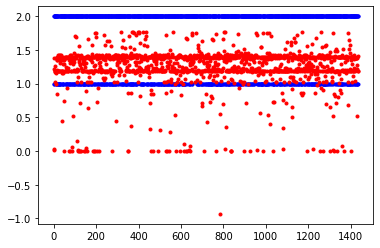

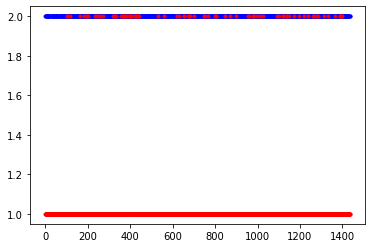

RULES: 257
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.709901, Validation cost: 1.699247
Epoch 20, Train cost: 1.480912, Validation cost: 1.454166
Epoch 40, Train cost: 1.114426, Validation cost: 1.101776
Epoch 60, Train cost: 0.868131, Validation cost: 0.855579
Epoch 80, Train cost: 0.677897, Validation cost: 0.683228



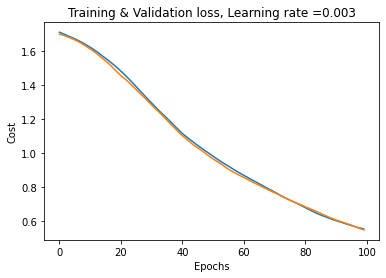

Accuracy: 0.6928969359331476


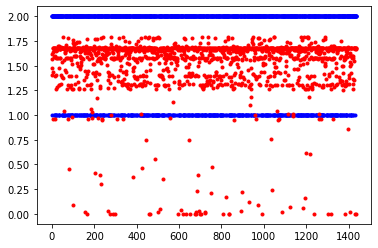

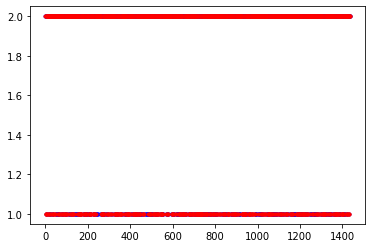

RULES: 127
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.737858, Validation cost: 1.735069
Epoch 20, Train cost: 1.590266, Validation cost: 1.587295
Epoch 40, Train cost: 1.364385, Validation cost: 1.359357
Epoch 60, Train cost: 1.096209, Validation cost: 1.087093
Epoch 80, Train cost: 0.828840, Validation cost: 0.838903



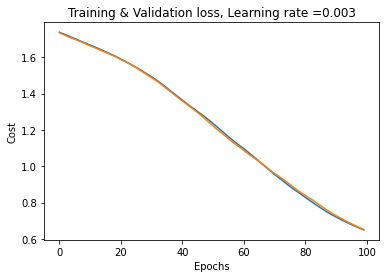

Accuracy: 0.5341225626740947


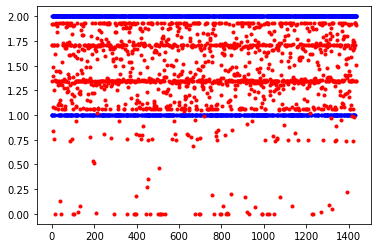

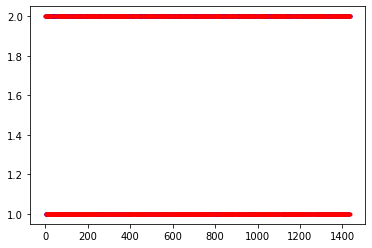

RULES: 260
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.733283, Validation cost: 1.733580
Epoch 20, Train cost: 1.592375, Validation cost: 1.582102
Epoch 40, Train cost: 1.295006, Validation cost: 1.283671
Epoch 60, Train cost: 1.016378, Validation cost: 0.997990
Epoch 80, Train cost: 0.815597, Validation cost: 0.805614



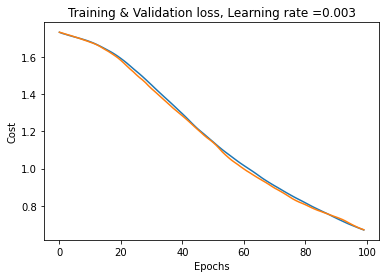

Accuracy: 0.5167130919220055


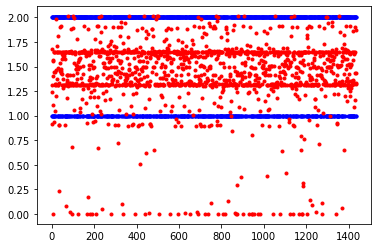

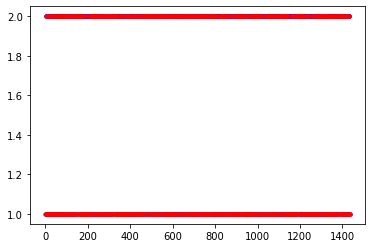

RULES: 50
(4594, 28) (4594,)
(1436, 28) (1436,)
(1149,) (1149,)
1 2 1 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, Train cost: 1.729212, Validation cost: 1.732396
Epoch 20, Train cost: 1.637757, Validation cost: 1.629915


In [ ]:
from geneticalgorithm import geneticalgorithm as ga

# pearson's correlation coefficient for contribution to the predictability

# time of samples later, alpha, number of epochs, membership functions Gaussian

# m or no.of rules, features to select, channels to select, loss function

def training_objective(X): # objective function to minimize final loss and determine optimum # of rules 
    m = int(X[0])  # number of rules (14-1000)
    print('RULES:', m)
    x_train_, x_test_, y_train_, y_test_, x_val_, y_val_ = create_feature_dataset([0,3])
    x_train_ = np.nan_to_num(x_train_, copy=True, nan=0.0, posinf=None, neginf=None)
    x_test_ = np.nan_to_num(x_test_, copy=True, nan=0.0, posinf=None, neginf=None)
    x_val_ = np.nan_to_num(x_val_, copy=True, nan=0.0, posinf=None, neginf=None)

    x_train_ = scale_std(x_train_)
    x_val_ = scale_std(x_val_)
    x_test_ = scale_std(x_test_)

    alpha = 3e-3 
    num_epochs = 100

    data = [x_train_, y_train_, x_test_, y_test_]
    fis, final_loss = train_anfis(data, x_train_.shape[1], m, alpha, num_epochs, True)

    return final_loss # minimize final_loss


varbound=np.array([[28,300]])
vartype=np.array([['int']])
model=ga(function=training_objective, dimension=1, variable_type_mixed=vartype, variable_boundaries=varbound)
model.run()

# GA-ANFIS